In [5]:
import pandas as pd
import geopandas as gpd
import scipy.stats as stats
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as pltc
import numpy as np
import folium
from folium import plugins
from folium.plugins import HeatMap
import seaborn
import rasterio

In [6]:
#pull in data
all_df = pd.read_csv('../data/US_Accidents_Dec20_Updated.csv')

In [7]:
#read in shapefiles for state boundries
states = gpd.read_file('../data/shp/cb_2018_us_state_500k.shp')

In [8]:
#pull out columns that we are interested in working with from data
some_data_df = all_df[['ID','Severity','Start_Time','Start_Lat','Start_Lng','City','County','State','Zipcode','Sunrise_Sunset','Civil_Twilight']].copy()

In [9]:
#Focus on state of WI so make new DataFrame with only WI data
wi_df = some_data_df[some_data_df['State']=='WI'].copy()

In [10]:
#Make a Geopandas DataFrame for Maps
some_data_geo = gpd.GeoDataFrame(some_data_df, geometry=gpd.points_from_xy(some_data_df.Start_Lng, some_data_df.Start_Lat))

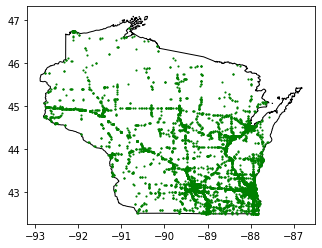

In [32]:
#Test simple plot of State Outline with Accident Data Displayed
base = states[states.NAME=='Wisconsin'].plot(color='white', edgecolor='black')
some_data_geo[some_data_geo.State == 'WI'].plot(ax=base, marker='.', color='green', markersize=5);

In [398]:
#Bring in WI base map
loc = ctx.Place("Wisconsin") 
loc.bbox
# img, ext = ctx.bounds2img(w=loc.bbox[0],s=loc.bbox[1],e=loc.bbox[2],n=loc.bbox[3])
# # warped_img = ctx.tile.warp_tiles(loc.im,loc.bbox_map)img, ext = cx.bounds2img(w, s, e, n)
# # Render image
# warped_img, warped_ext = ctx.warp_tiles(img, ext, "EPSG:4326")
# plt.imshow(img, extent=ext)

[-92.8893149, 42.4919515, -86.249548, 47.3025]

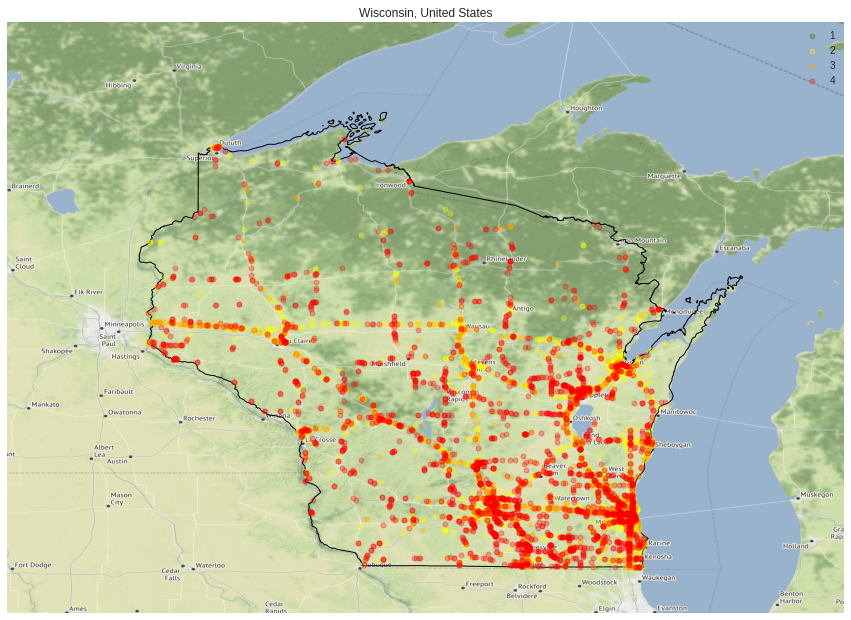

In [400]:
#Make Plot
fig, ax = plt.subplots(figsize=(15, 15))
#Bring in Base Map
ctx.plot_map(loc, ax=ax)
#Bring in State Outline
states[states.NAME=='Wisconsin'].plot(ax=ax, color= 'none', edgecolor='black')
#Plot data from GeoFrames with different colors for Severity
ax=some_data_geo[(some_data_geo.State == 'WI')&(some_data_geo.Severity==1)].plot(ax=ax, marker='.', color='green', markersize=100,alpha=.3, label = '1')
ax=some_data_geo[(some_data_geo.State == 'WI')&(some_data_geo.Severity==2)].plot(ax=ax, marker='.', color='yellow', markersize=100,alpha=.3, label = '2')
ax=some_data_geo[(some_data_geo.State == 'WI')&(some_data_geo.Severity==3)].plot(ax=ax, marker='.', color='orange', markersize=100,alpha=.3, label = '3')
ax=some_data_geo[(some_data_geo.State == 'WI')&(some_data_geo.Severity==4)].plot(ax=ax, marker='.', color='red', markersize=100,alpha=.3, label = '4')
ax.legend()
plt.savefig(f'../data/Wisconsin Map', format='png',bbox_inches='tight')
plt.show()

In [11]:
#Converting the Start_Time String into a datetime
some_data_df['Start_Time'] = pd.to_datetime(some_data_df['Start_Time'])

In [12]:
#Pull the Years and Months out of the Date Time as sperate Columns
some_data_df['year']=some_data_df['Start_Time'].dt.year
some_data_df['month']=some_data_df['Start_Time'].dt.month
some_data_df['hour']=some_data_df['Start_Time'].dt.hour

In [13]:
#Count by Severity
sev_df = some_data_df.groupby(some_data_df.Severity, as_index=False)['ID'].count().copy()

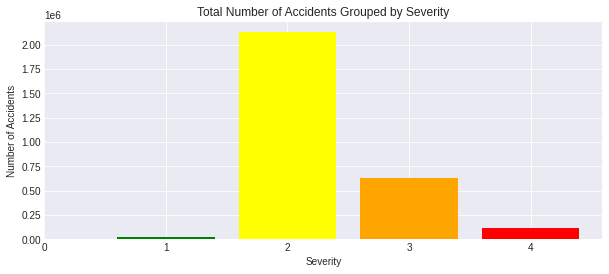

In [246]:
#Make Plot
fig, ax = plt.subplots(figsize=(10, 4))
x = ['0','1','2','3','4']
ax.bar(sev_df['Severity'],sev_df['ID'],color=['green','yellow','orange','red'])
plt.xticks(np.arange(len(sev_df['Severity'])+1),x)
ax.set_xlabel('Severity')
ax.set_ylabel('Number of Accidents')
plt.title('Total Number of Accidents Grouped by Severity')
plt.savefig(f'../data/Total_Accidents_Severity', format='png',bbox_inches='tight')
plt.show()

In [142]:
#Count WI data by Severity
wi_sev_df = wi_df.groupby(wi_df.Severity, as_index=False)['ID'].count().copy()

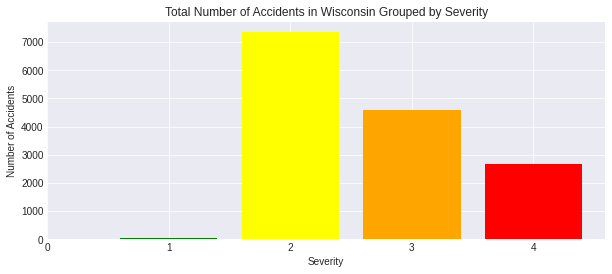

In [247]:
#Make Plot
fig, ax = plt.subplots(figsize=(10, 4))
x = ['0','1','2','3','4']
ax.bar(wi_sev_df['Severity'],wi_sev_df['ID'],color=['green','yellow','orange','red'])
plt.xticks(np.arange(len(wi_sev_df['Severity'])+1),x)
ax.set_xlabel('Severity')
ax.set_ylabel('Number of Accidents')
plt.title('Total Number of Accidents in Wisconsin Grouped by Severity')
plt.savefig(f'../data/WI_Accidents_Severity', format='png',bbox_inches='tight')
plt.show()

In [71]:
#Count Data by year
year_df=some_data_df.groupby(some_data_df.year, as_index=False)['ID'].count().copy()

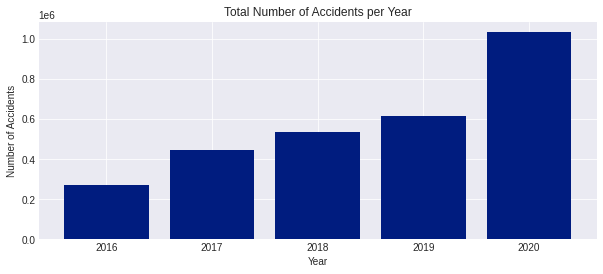

In [144]:
#Make Plot
fig, ax = plt.subplots(figsize=(10, 4))
x = ['0','1','2','3','4']
ax.bar(year_df['year'],year_df['ID'])
ax.set_xlabel('Year')
ax.set_ylabel('Number of Accidents')
plt.title('Total Number of Accidents per Year')
plt.show()

In [73]:
month_df=some_data_df.groupby(some_data_df.month, as_index=False)['ID'].count().copy()

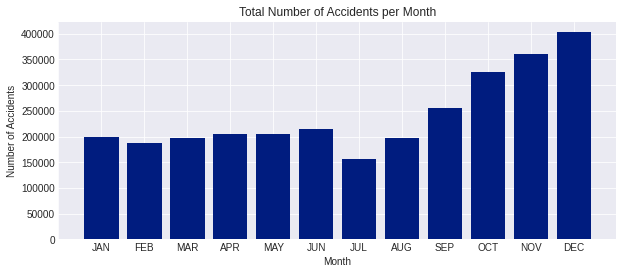

In [145]:
#Make Plot
fig, ax = plt.subplots(figsize=(10, 4))
x = ['','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
ax.bar(month_df['month'],month_df['ID'])
plt.xticks(np.arange(len(x)),x)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Accidents')
plt.title('Total Number of Accidents per Month')
plt.show()

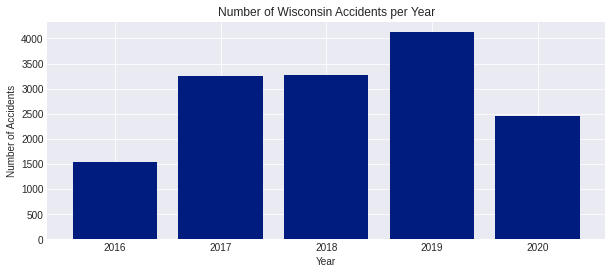

In [146]:
#Count Data by year
wi_year_df=some_data_df[(some_data_df.State == 'WI')].groupby((some_data_df[(some_data_df.State == 'WI')].year)).count().copy()
#Make Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(wi_year_df.index,wi_year_df['ID'])
ax.set_xlabel('Year')
ax.set_ylabel('Number of Accidents')
plt.title('Number of Wisconsin Accidents per Year')
plt.show()

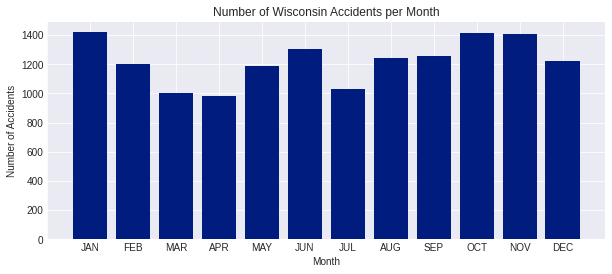

In [147]:
wi_month_df=some_data_df[(some_data_df.State == 'WI')].groupby((some_data_df[(some_data_df.State == 'WI')].month)).count().copy()
#Make Plot
fig, ax = plt.subplots(figsize=(10, 4))
x = ['','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
ax.bar(wi_month_df.index,wi_month_df['ID'])
plt.xticks(np.arange(len(x)),x)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Accidents')
plt.title('Number of Wisconsin Accidents per Month')
plt.show()

In [148]:
total_sev_df = some_data_df.groupby(some_data_df.Severity)

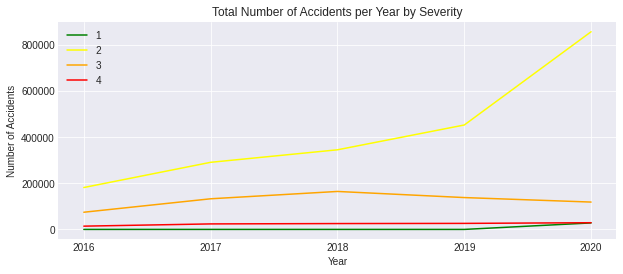

In [249]:
#Make Plot
fig, ax = plt.subplots(figsize=(10, 4))
# np.linspace()
x=some_data_df[(some_data_df.Severity==1)].groupby([some_data_df.year]).count().index
y=some_data_df[(some_data_df.Severity==1)].groupby([some_data_df.year]).count()['year']
ax.plot(x,y,color='green',label='1')
x=some_data_df[(some_data_df.Severity==2)].groupby([some_data_df.year]).count().index
y=some_data_df[(some_data_df.Severity==2)].groupby([some_data_df.year]).count()['year']
ax.plot(x,y,color='yellow',label='2')
x=some_data_df[(some_data_df.Severity==3)].groupby([some_data_df.year]).count().index
y=some_data_df[(some_data_df.Severity==3)].groupby([some_data_df.year]).count()['year']
ax.plot(x,y,color='orange',label='3')
x=some_data_df[(some_data_df.Severity==4)].groupby([some_data_df.year]).count().index
y=some_data_df[(some_data_df.Severity==4)].groupby([some_data_df.year]).count()['year']
ax.plot(x,y,color='red',label='4')
plt.legend()
plt.xticks([2016,2017,2018,2019,2020],['2016','2017','2018','2019','2020'])
ax.set_xlabel('Year')
ax.set_ylabel('Number of Accidents')
plt.title('Total Number of Accidents per Year by Severity')
plt.savefig(f'../data/Total_Accidents_Severity_line', format='png',bbox_inches='tight')
plt.show()

In [248]:
some_data_df[(some_data_df.Severity==4)].groupby([some_data_df.year]).count()

ID  Severity  Start_Time  Start_Lat  Start_Lng   City  County  State  \
year                                                                            
2016  14269     14269       14269      14269      14269  14265   14269  14269   
2017  23970     23970       23970      23970      23970  23963   23970  23970   
2018  25489     25489       25489      25489      25489  25488   25489  25489   
2019  26250     26250       26250      26250      26250  26248   26250  26250   
2020  29166     29166       29166      29166      29166  29160   29166  29166   

      Zipcode  Sunrise_Sunset  Civil_Twilight  geometry   year  month   hour  
year                                                                          
2016    14264           14265           14265     14269  14269  14269  14269  
2017    23951           23963           23963     23970  23970  23970  23970  
2018    25462           25488           25488     25489  25489  25489  25489  
2019    26228           26248           26248     26250  26250  26250  26250  
2020    29153           29160           29160     29166  29166  29166  29166

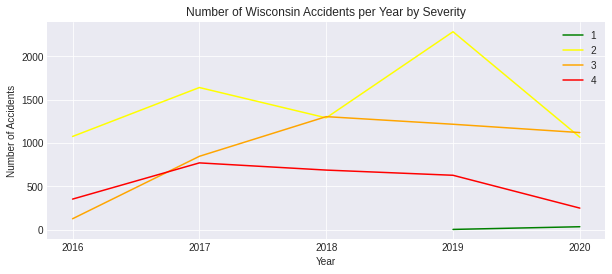

In [151]:
#Make Plot
fig, ax = plt.subplots(figsize=(10, 4))
# np.linspace()
x=some_data_df[(some_data_df.State == 'WI')&(some_data_df.Severity==1)].groupby([some_data_df.year]).count().index
y=some_data_df[(some_data_df.State == 'WI')&(some_data_df.Severity==1)].groupby([some_data_df.year]).count()['year']
ax.plot(x,y,color='green',label='1')
x=some_data_df[(some_data_df.State == 'WI')&(some_data_df.Severity==2)].groupby([some_data_df.year]).count().index
y=some_data_df[(some_data_df.State == 'WI')&(some_data_df.Severity==2)].groupby([some_data_df.year]).count()['year']
ax.plot(x,y,color='yellow',label='2')
x=some_data_df[(some_data_df.State == 'WI')&(some_data_df.Severity==3)].groupby([some_data_df.year]).count().index
y=some_data_df[(some_data_df.State == 'WI')&(some_data_df.Severity==3)].groupby([some_data_df.year]).count()['year']
ax.plot(x,y,color='orange',label='3')
x=some_data_df[(some_data_df.State == 'WI')&(some_data_df.Severity==4)].groupby([some_data_df.year]).count().index
y=some_data_df[(some_data_df.State == 'WI')&(some_data_df.Severity==4)].groupby([some_data_df.year]).count()['year']
ax.plot(x,y,color='red',label='4')
plt.legend()
plt.xticks([2016,2017,2018,2019,2020],['2016','2017','2018','2019','2020'])
ax.set_xlabel('Year')
ax.set_ylabel('Number of Accidents')
plt.title('Number of Wisconsin Accidents per Year by Severity')
plt.show()

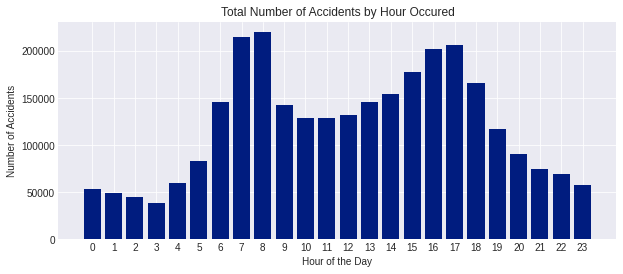

In [23]:
hour_df = some_data_df.groupby(some_data_df.hour, as_index=False)['ID'].count()
plt.style.use('seaborn-dark-palette')
#Make Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(hour_df.hour,hour_df.ID)
plt.xticks(np.arange(len(hour_df.index)),hour_df.index)
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Number of Accidents')
plt.title('Total Number of Accidents by Hour Occured')
plt.savefig(f'../data/Total_Accidents_by_hour', format='png',bbox_inches='tight')
plt.show()

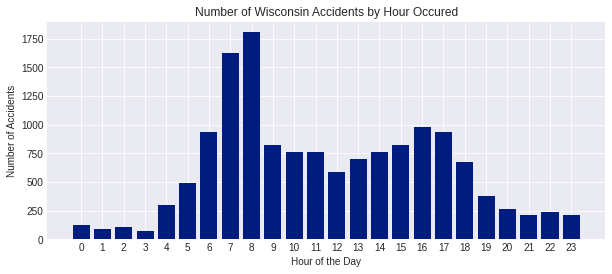

In [153]:
wi_hour_df = some_data_df[(some_data_df.State == 'WI')].groupby(some_data_df[(some_data_df.State == 'WI')].hour, as_index=False)['ID'].count()
#Make Plot
fig, ax = plt.subplots(figsize=(10, 4))
plt.style.use('seaborn-dark-palette')
ax.bar(wi_hour_df.index,wi_hour_df.ID)
plt.xticks(np.arange(len(hour_df.index)),hour_df.index)
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Number of Accidents')
plt.title('Number of Wisconsin Accidents by Hour Occured')
plt.show()

In [82]:
some_data_df.groupby(some_data_df.Sunrise_Sunset).count()

ID  Severity  Start_Time  Start_Lat  Start_Lng     City  \
Sunrise_Sunset                                                                 
Day             1941068   1941068     1941068    1941068    1941068  1941068   
Night            965432    965432      965432     965432     965432   965432   

                 County    State  Zipcode  Civil_Twilight  geometry     year  \
Sunrise_Sunset                                                                 
Day             1941068  1941068  1940473         1941068   1941068  1941068   
Night            965432   965432   964913          965432    965432   965432   

                  month     hour  
Sunrise_Sunset                    
Day             1941068  1941068  
Night            965432   965432

In [54]:
m = folium.Map(location=[45, -90], zoom_start=8)
locations = some_data_df[['Start_Lat', 'Start_Lng']]
locationlist = locations.values.tolist()
# type(locationlist[0])

# for idx, point in enumerate(range(0, len(locationlist))):
#     if wi_df.Severity.iloc[idx]==1:
#         colors='green'
#     elif wi_df.Severity.iloc[idx]==2:
#         colors='beige'
#     elif wi_df.Severity.iloc[idx]==3:
#         colors='orange'
#     else:
#         colors='red'
folium.Marker(locationlist[point],icon=folium.Icon(color=colors, icon='circle')).add_to(m)
HeatMap(locationlist,min_opacity=0.3).add_to(m)

In [56]:
m.save("testMap.html")

In [57]:
#file:///home/stingl/DSI/capstones/capstone1/testMap.html

In [83]:
def plot_number_accidents_by_hour(some_data_df,st_abr):
    '''
    Arguments
         some_data_df: a pandas dataframe
         st_abr: a str for the state abbreviation ex. WI for Wisconsin
    
    Output
         saves graph
    '''
    wi_hour_df = some_data_df[(some_data_df.State == st_abr)].groupby(some_data_df[(some_data_df.State == st_abr)].hour, as_index=False)['ID'].count()
    #Make Plot
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(wi_hour_df.index,wi_hour_df.ID)
    plt.xticks(np.arange(len(wi_hour_df.index)),wi_hour_df.index)
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Number of Accidents')
    plt.title(f'Number of {st_abr} Accidents by Hour Occured')
    plt.savefig(f'../data/{st_abr}', format='png')
    plt.close()

In [84]:
plot_number_accidents_by_hour(some_data_df,'NM')

In [85]:
wi_df = some_data_df[some_data_df['State']=='WI'].copy()

In [86]:
ca_df = some_data_df[some_data_df['State']=='CA'].copy()

In [87]:
ny_df = some_data_df[some_data_df['State']=='NY'].copy()

In [88]:
some_data_df[some_data_df.year==2020].describe()

Severity     Start_Lat     Start_Lng       year         month  \
count  1.033828e+06  1.033828e+06  1.033828e+06  1033828.0  1.033828e+06   
mean   2.143931e+00  3.620894e+01 -9.642277e+01     2020.0  7.743209e+00   
std    4.840848e-01  5.113307e+00  1.804331e+01        0.0  3.784707e+00   
min    1.000000e+00  2.457058e+01 -1.244975e+02     2020.0  1.000000e+00   
25%    2.000000e+00  3.351991e+01 -1.178764e+02     2020.0  4.000000e+00   
50%    2.000000e+00  3.583630e+01 -9.070261e+01     2020.0  9.000000e+00   
75%    2.000000e+00  3.996984e+01 -8.037207e+01     2020.0  1.100000e+01   
max    4.000000e+00  4.899957e+01 -6.748413e+01     2020.0  1.200000e+01   

               hour  
count  1.033828e+06  
mean   1.232560e+01  
std    6.517578e+00  
min    0.000000e+00  
25%    7.000000e+00  
50%    1.300000e+01  
75%    1.700000e+01  
max    2.300000e+01

In [89]:
wi_df[wi_df.year==2020].groupby('Severity').count()

ID  Start_Time  Start_Lat  Start_Lng  City  County  State  \
Severity                                                                
1           32          32         32         32    32      32     32   
2         1066        1066       1066       1066  1066    1066   1066   
3         1119        1119       1119       1119  1119    1119   1119   
4          247         247        247        247   247     247    247   

          Zipcode  Sunrise_Sunset  Civil_Twilight  geometry  year  month  hour  
Severity                                                                        
1              32              32              32        32    32     32    32  
2            1066            1066            1066      1066  1066   1066  1066  
3            1119            1119            1119      1119  1119   1119  1119  
4             247             247             247       247   247    247   247

In [90]:
ca_df[ca_df.year==2020].groupby('Severity').count()

ID  Start_Time  Start_Lat  Start_Lng    City  County   State  \
Severity                                                                     
1           5560        5560       5560       5560    5560    5560    5560   
2         255006      255006     255006     255006  255004  255006  255006   
3          17567       17567      17567      17567   17567   17567   17567   
4           2365        2365       2365       2365    2365    2365    2365   

          Zipcode  Sunrise_Sunset  Civil_Twilight  geometry    year   month  \
Severity                                                                      
1            5551            5560            5560      5560    5560    5560   
2          254882          255004          255004    255006  255006  255006   
3           17558           17567           17567     17567   17567   17567   
4            2364            2365            2365      2365    2365    2365   

            hour  
Severity          
1           5560  
2         255006  
3          17567  
4           2365

In [91]:
ny_df[ny_df.year==2020].groupby('Severity').count()

ID  Start_Time  Start_Lat  Start_Lng   City  County  State  \
Severity                                                                  
1           708         708        708        708    706     708    708   
2         32300       32300      32300      32300  32296   32300  32300   
3          7089        7089       7089       7089   7087    7089   7089   
4          2069        2069       2069       2069   2069    2069   2069   

          Zipcode  Sunrise_Sunset  Civil_Twilight  geometry   year  month  \
Severity                                                                    
1             708             706             706       708    708    708   
2           32300           32296           32296     32300  32300  32300   
3            7089            7087            7087      7089   7089   7089   
4            2069            2069            2069      2069   2069   2069   

           hour  
Severity         
1           708  
2         32300  
3          7089  
4          2069

In [92]:
ca_df.describe()['Severity'].iloc[0]

730744.0

In [47]:
def get_percentages_of_severity_year(df,year):
    total = df[df.year==year].groupby('Severity').count()['ID'].sum()
    percent_severity = []
    for i in range(4):
        percent_severity.append(df[df.year==year].groupby('Severity').count().iloc[i]['ID']/total)
    return percent_severity

def get_percentages_of_severity(df):
    total = df.groupby('Severity').count()['ID'].sum()
    percent_severity = []
    for i in range(4):
        percent_severity.append(df.groupby('Severity').count().iloc[i]['ID']/total)
    return percent_severity
def get_percentages_of_severity_hour(df,hour):
    total = df[df.hour==hour].groupby('Severity').count()['ID'].sum()
    percent_severity = []
    for i in range(4):
        percent_severity.append(df[df.hour==hour].groupby('Severity').count().iloc[i]['ID']/total)
    return percent_severity

In [48]:
get_percentages_of_severity_hour(some_data_df,'0')

IndexError: single positional indexer is out-of-bounds

In [94]:
get_percentages_of_severity(ca_df)

[0.007777005353447993,
 0.7935610829510745,
 0.18688213656218866,
 0.011779775133288813]

In [95]:
get_percentages_of_severity(wi_df)

[0.0022496421023928013,
 0.5011248210511964,
 0.31399550071579524,
 0.1826300361306156]

In [96]:
get_percentages_of_severity(ny_df)

[0.005674613238650774,
 0.6590556048693887,
 0.27631245244737507,
 0.058957329444585344]

In [97]:
get_percentages_of_severity(some_data_df)

[0.009891591923237035,
 0.7325588916297681,
 0.21655880905935093,
 0.04099070738764402]

In [98]:
get_percentages_of_severity_year(some_data_df,2020)

[0.027349810606793392,
 0.8295809360938183,
 0.11485759720185562,
 0.028211656097532664]

In [99]:
get_percentages_of_severity_year(ca_df,2020)

[0.019821888213106688,
 0.9091187815955907,
 0.06262789752511605,
 0.008431432666186569]

In [100]:
get_percentages_of_severity_year(wi_df,2020)

[0.012987012987012988,
 0.43262987012987014,
 0.45413961038961037,
 0.1002435064935065]

In [101]:
get_percentages_of_severity_year(ny_df,2020)

[0.01679077930085851,
 0.7660200161267372,
 0.1681212351183418,
 0.04906796945406251]

In [102]:
stats.mannwhitneyu(wi_df[wi_df.year==2020]['Severity'].to_list(), some_data_df[some_data_df.year==2020]['Severity'].to_list(), alternative="greater")

MannwhitneyuResult(statistic=1797251386.5, pvalue=0.0)

In [103]:
stats.mannwhitneyu(wi_df[wi_df.year==2020]['Severity'].to_list(), ny_df[ny_df.year==2020]['Severity'].to_list(), alternative="greater")

MannwhitneyuResult(statistic=69043684.0, pvalue=6.522236685571293e-288)

In [104]:
stats.mannwhitneyu(wi_df[wi_df.year==2020]['Severity'].to_list(), ca_df[ca_df.year==2020]['Severity'].to_list(), alternative="greater")

MannwhitneyuResult(statistic=512327137.0, pvalue=0.0)

In [105]:
la = ca_df[ca_df['City']=='Los Angeles']['Severity']

In [106]:
mil = wi_df[wi_df.City=='Milwaukee']['Severity']

In [107]:
stats.mannwhitneyu(mil,la, alternative="greater")

MannwhitneyuResult(statistic=224579619.5, pvalue=3.247572366087469e-178)

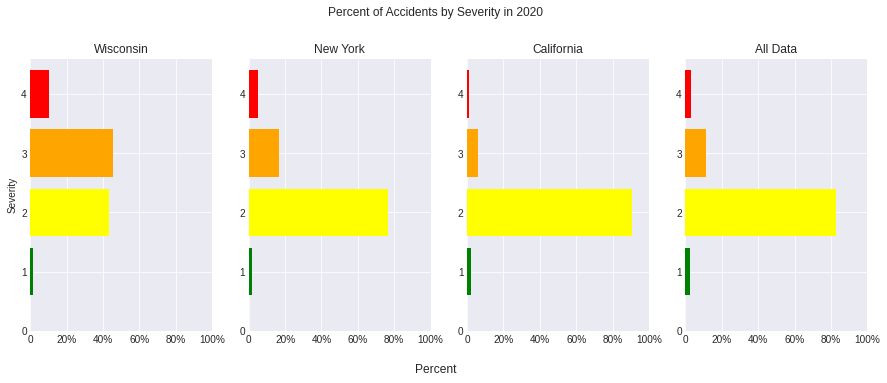

In [292]:
#Make Plot
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(1,4,figsize=(15, 5))
plt.style.use('seaborn-darkgrid')
x = [1,2,3,4]
ax[0].barh(x,get_percentages_of_severity_year(wi_df,2020),color=['green','yellow','orange','red'])
ax[2].barh(x,get_percentages_of_severity_year(ca_df,2020),color=['green','yellow','orange','red'])
ax[1].barh(x,get_percentages_of_severity_year(ny_df,2020),color=['green','yellow','orange','red'])
ax[3].barh(x,get_percentages_of_severity_year(some_data_df,2020),color=['green','yellow','orange','red'])
ax[0].set_xticks(np.linspace(0,1,11,)[::2])
ax[0].set_xticklabels(['0','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'][::2])
ax[1].set_xticks(np.linspace(0,1,11)[::2])
ax[1].set_xticklabels(['0','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'][::2])
ax[2].set_xticks(np.linspace(0,1,11)[::2])
ax[2].set_xticklabels(['0','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'][::2])
ax[3].set_xticks(np.linspace(0,1,11)[::2])
ax[3].set_xticklabels(['0','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'][::2])
ax[0].set_ylabel('Severity')
ax[0].set_yticks(np.arange(len(x)+1))
ax[1].set_yticks(np.arange(len(x)+1))
ax[2].set_yticks(np.arange(len(x)+1))
ax[3].set_yticks(np.arange(len(x)+1))
# ax.set_ylabel('Number of Accidents')
ax[0].set_title('Wisconsin')
ax[2].set_title('California')
ax[1].set_title('New York')
ax[3].set_title('All Data')
fig.text(.5,1,'Percent of Accidents by Severity in 2020',ha='center',size='large')
fig.text(.5,0,'Percent',ha='center',va='bottom',size='large')
fig.align_xlabels(ax)
plt.savefig(f'../data/Percent of Accidents by Severity2020', format='jpeg',bbox_inches='tight')
plt.show()

In [112]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [113]:
np.linspace(0,1,11,)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

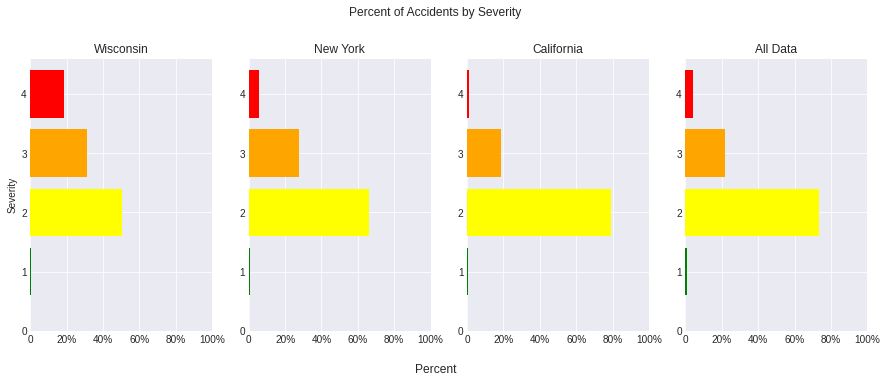

In [470]:
#Make Plot
fig, ax = plt.subplots(1,4,figsize=(15, 5))
plt.style.use('seaborn-dark-palette')
x = [1,2,3,4]
ax[0].barh(x,get_percentages_of_severity(wi_df),color=['green','yellow','orange','red'])
ax[2].barh(x,get_percentages_of_severity(ca_df),color=['green','yellow','orange','red'])
ax[1].barh(x,get_percentages_of_severity(ny_df),color=['green','yellow','orange','red'])
ax[3].barh(x,get_percentages_of_severity(some_data_df),color=['green','yellow','orange','red'])
ax[0].set_xticks(np.linspace(0,1,11,)[::2])
ax[0].set_xticklabels(['0','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'][::2])
ax[1].set_xticks(np.linspace(0,1,11)[::2])
ax[1].set_xticklabels(['0','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'][::2])
ax[2].set_xticks(np.linspace(0,1,11)[::2])
ax[2].set_xticklabels(['0','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'][::2])
ax[3].set_xticks(np.linspace(0,1,11)[::2])
ax[3].set_xticklabels(['0','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'][::2])
ax[0].set_ylabel('Severity')
ax[0].set_yticks(np.arange(len(x)+1))
ax[1].set_yticks(np.arange(len(x)+1))
ax[2].set_yticks(np.arange(len(x)+1))
ax[3].set_yticks(np.arange(len(x)+1))
# ax.set_ylabel('Number of Accidents')
ax[0].set_title('Wisconsin')
ax[2].set_title('California')
ax[1].set_title('New York')
ax[3].set_title('All Data')
# ax[1].set_xlabel('Percent')
fig.text(.5,1,'Percent of Accidents by Severity',ha='center',size='large')
fig.text(.5,0,'Percent',ha='center',va='bottom',size='large')
plt.savefig(f'../data/Percent of Accidents by Severity', format='svg', dpi=600,bbox_inches='tight')
plt.show()

In [115]:
rhi = wi_df[wi_df.City=='Rhinelander']['Severity']

In [116]:
stats.mannwhitneyu(rhi,la, alternative="greater")

MannwhitneyuResult(statistic=1046215.5, pvalue=4.1375346923860664e-17)

In [117]:
stats.mannwhitneyu(rhi,mil, alternative="greater")

MannwhitneyuResult(statistic=83312.5, pvalue=3.573447169453813e-12)

In [118]:
ojai = ca_df[ca_df.City=='Ojai']['Severity']

In [119]:
stats.mannwhitneyu(ojai,la, alternative="greater")

MannwhitneyuResult(statistic=8569398.0, pvalue=1.0)

In [120]:
stats.mannwhitneyu(rhi,ojai, alternative="greater")

MannwhitneyuResult(statistic=4931.5, pvalue=1.7432096443464852e-40)

In [121]:
new_york=ny_df[ny_df.City=='New York']['Severity']

In [122]:
stats.mannwhitneyu(new_york,la, alternative="greater")

MannwhitneyuResult(statistic=262624178.0, pvalue=5.452753801921097e-19)

In [123]:
mad = wi_df[wi_df.City=='Madison']['Severity']

In [124]:
stats.mannwhitneyu(mad, mil, alternative="greater")

MannwhitneyuResult(statistic=2316453.0, pvalue=1.0)

array([[<AxesSubplot:title={'center':'Severity'}>,
        <AxesSubplot:title={'center':'Start_Time'}>,
        <AxesSubplot:title={'center':'Start_Lat'}>],
       [<AxesSubplot:title={'center':'Start_Lng'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'hour'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

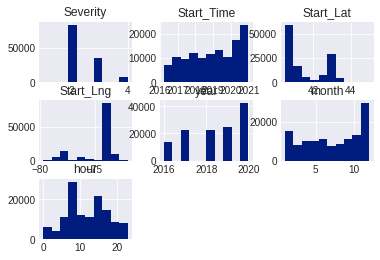

In [125]:
ny_df.hist()

<AxesSubplot:>

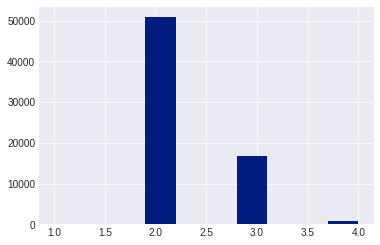

In [126]:
la.hist()

<AxesSubplot:>

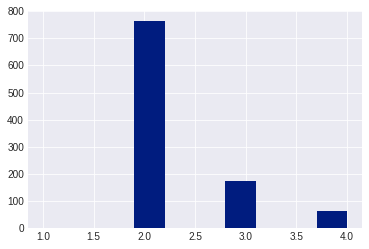

In [127]:
mad.hist()

<AxesSubplot:>

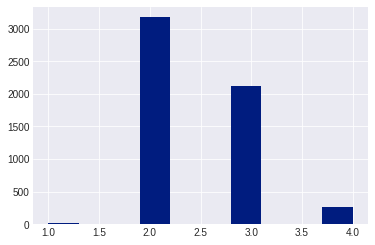

In [128]:
mil.hist()

<AxesSubplot:>

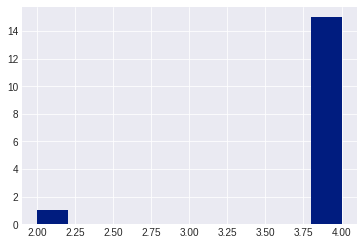

In [129]:
rhi.hist()

In [273]:
def state_severity(df,state):
    #Count by Severity
    sev_df = df[df.State==state].groupby(df[df.State==state].Severity)['ID'].count().copy()
    fig, ax = plt.subplots(figsize=(10, 4))
    x = ['0','1','2','3','4']
    ax.bar(sev_df.index,sev_df,color=['green','yellow','orange','red'])
    plt.xticks([0,1,2,3,4],x)
    ax.set_xlabel('Severity')
    ax.set_ylabel('Number of Accidents')
    plt.title(f'Number of {state} Accidents Grouped by Severity')
    plt.savefig(f'../data/{state}_severity', format='jpeg',bbox_inches='tight')
    plt.close()

In [275]:
state_severity(some_data_df,'NY')

In [131]:
sv = some_data_df[some_data_df.State=='ID'].groupby(some_data_df[some_data_df.State=='ID'].Severity).count().unstack(fill_value=0).to_frame().stack()['ID']

In [132]:
sv

Severity   
2         0    3678
3         0     169
4         0     318
dtype: int64

In [133]:
some_data_df.groupby(some_data_df.State).count().index

Index(['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'IA', 'ID',
       'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS',
       'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR',
       'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV',
       'WY'],
      dtype='object', name='State')

In [134]:
for state in some_data_df.groupby(some_data_df.State).count().index:
#     state_severity(some_data_df,state)
    plot_number_accidents_by_hour(some_data_df, state)

In [135]:
some_data_df[some_data_df.State=='ID'].pivot_table(index=some_data_df.Severity, values='ID', fill_value=0, aggfunc='count').unstack().to_frame()

0
   Severity      
ID 2         3678
   3          169
   4          318

In [136]:
some_data_df.groupby(some_data_df.State).count()['ID'].sort_values()

State
SD       217
WY       419
ND       463
VT       555
ME      2266
MT      3333
WV      3421
NM      3973
ID      4165
DE      4625
AR      4726
DC      5201
MS      5419
NH      6250
KS      7444
NV      7812
RI      8314
IA      9492
NE     13678
WI     14669
KY     15296
CT     24054
IN     24993
MA     25121
MO     28674
AL     33290
OK     35105
CO     37280
UT     46897
OH     47836
WA     49455
LA     50103
NJ     50214
MD     52755
TN     55495
AZ     61707
MI     67073
GA     69536
IL     77626
MN     79712
VA     89730
PA     89745
OR     98352
SC    120462
NC    122797
NY    126176
TX    226640
FL    263300
CA    730744
Name: ID, dtype: int64

In [137]:
some_data_df[some_data_df['State']=='WI']

ID  Severity          Start_Time  Start_Lat  Start_Lng  \
154          A-155         2 2020-11-04 06:24:33  44.347912 -88.737572   
556          A-557         2 2019-09-13 09:44:45  42.988430 -87.984047   
617          A-618         2 2017-08-02 07:43:04  43.027510 -88.012630   
652          A-653         2 2019-05-24 15:47:26  42.614790 -87.952270   
1008        A-1009         4 2019-02-04 08:18:21  44.854678 -88.349982   
...            ...       ...                 ...        ...        ...   
2905597  A-2905598         3 2018-12-15 07:34:00  43.035640 -87.939840   
2906045  A-2906046         3 2020-10-15 16:08:14  43.049431 -87.926147   
2906478  A-2906479         2 2020-11-24 08:37:58  43.059845 -88.052773   
2906519  A-2906520         4 2018-03-31 14:01:09  45.505072 -92.528270   
2906596  A-2906597         2 2017-08-18 07:23:31  44.541946 -88.091049   

               City     County State     Zipcode Sunrise_Sunset  \
154      New London  Outagamie    WI       54961          Night   
556       Milwaukee  Milwaukee    WI       53219            Day   
617       Milwaukee  Milwaukee    WI       53214            Day   
652         Kenosha    Kenosha    WI       53144            Day   
1008        Gillett     Oconto    WI       54124            Day   
...             ...        ...   ...         ...            ...   
2905597   Milwaukee  Milwaukee    WI       53233            Day   
2906045   Milwaukee  Milwaukee    WI       53205            Day   
2906478   Milwaukee  Milwaukee    WI  53226-2233            Day   
2906519    Milltown       Polk    WI  54858-9018            Day   
2906596   Green Bay      Brown    WI       54313            Day   

        Civil_Twilight                    geometry  year  month  hour  
154                Day  POINT (-88.73757 44.34791)  2020     11     6  
556                Day  POINT (-87.98405 42.98843)  2019      9     9  
617                Day  POINT (-88.01263 43.02751)  2017      8     7  
652                Day  POINT (-87.95227 42.61479)  2019      5    15  
1008               Day  POINT (-88.34998 44.85468)  2019      2     8  
...                ...                         ...   ...    ...   ...  
2905597            Day  POINT (-87.93984 43.03564)  2018     12     7  
2906045            Day  POINT (-87.92615 43.04943)  2020     10    16  
2906478            Day  POINT (-88.05277 43.05985)  2020     11     8  
2906519            Day  POINT (-92.52827 45.50507)  2018      3    14  
2906596            Day  POINT (-88.09105 44.54195)  2017      8     7  

[14669 rows x 15 columns]

In [138]:
reject_the_null=[]
for state in some_data_df.groupby(some_data_df.State).count().index:
    val = stats.mannwhitneyu(some_data_df[some_data_df['State']==state]['Severity'], some_data_df['Severity'], alternative="greater")
    if val[1]<.05:
        reject_the_null.append(state)
    print(f'For {state} < All Data the {val[1]}')
    

For AL < All Data the 1.0836759867585687e-10
For AR < All Data the 0.021906678261444948
For AZ < All Data the 1.0
For CA < All Data the 1.0
For CO < All Data the 0.0
For CT < All Data the 0.0
For DC < All Data the 1.5659702052315513e-17
For DE < All Data the 5.482964983492561e-40
For FL < All Data the 1.0
For GA < All Data the 0.0
For IA < All Data the 0.0
For ID < All Data the 1.0
For IL < All Data the 0.0
For IN < All Data the 0.0
For KS < All Data the 1.6625415741293962e-225
For KY < All Data the 0.0
For LA < All Data the 1.0
For MA < All Data the 2.05698397248294e-276
For MD < All Data the 0.0
For ME < All Data the 1.0
For MI < All Data the 0.0
For MN < All Data the 1.0
For MO < All Data the 0.0
For MS < All Data the 4.6486905026420496e-58
For MT < All Data the 1.0
For NC < All Data the 1.0
For ND < All Data the 1.0
For NE < All Data the 1.0
For NH < All Data the 1.0
For NJ < All Data the 9.953826565179384e-150
For NM < All Data the 1.4154941383082206e-93
For NV < All Data the 5.90

In [139]:
reject_the_null

['AL',
 'AR',
 'CO',
 'CT',
 'DC',
 'DE',
 'GA',
 'IA',
 'IL',
 'IN',
 'KS',
 'KY',
 'MA',
 'MD',
 'MI',
 'MO',
 'MS',
 'NJ',
 'NM',
 'NV',
 'NY',
 'OH',
 'RI',
 'TX',
 'VA',
 'VT',
 'WA',
 'WI',
 'WV',
 'WY']

In [241]:
def get_map(some_data_geo, state_name, st_abr):
    loc = ctx.Place(state_name) 
    #Make Plot
    fig, ax = plt.subplots(figsize=(15, 15))
    #Bring in Base Map
    ctx.plot_map(loc, ax=ax)
    #Bring in State Outline
    states[states.NAME==state_name].plot(ax=ax, color= 'none', edgecolor='black')
    #Plot data from GeoFrames with different colors for Severity
    ax=some_data_geo[(some_data_geo.State == st_abr)&(some_data_geo.Severity==1)].plot(ax=ax, marker='.', color='green', markersize=100,alpha=.3, label = '1')
    ax=some_data_geo[(some_data_geo.State == st_abr)&(some_data_geo.Severity==2)].plot(ax=ax, marker='.', color='yellow', markersize=100,alpha=.3, label = '2')
    ax=some_data_geo[(some_data_geo.State == st_abr)&(some_data_geo.Severity==3)].plot(ax=ax, marker='.', color='orange', markersize=100,alpha=.3, label = '3')
    ax=some_data_geo[(some_data_geo.State == st_abr)&(some_data_geo.Severity==4)].plot(ax=ax, marker='.', color='red', markersize=100,alpha=.3, label = '4')
    ax.legend()
    plt.savefig(f'../data/{state_name} Map', format='png',bbox_inches='tight')
    plt.show()

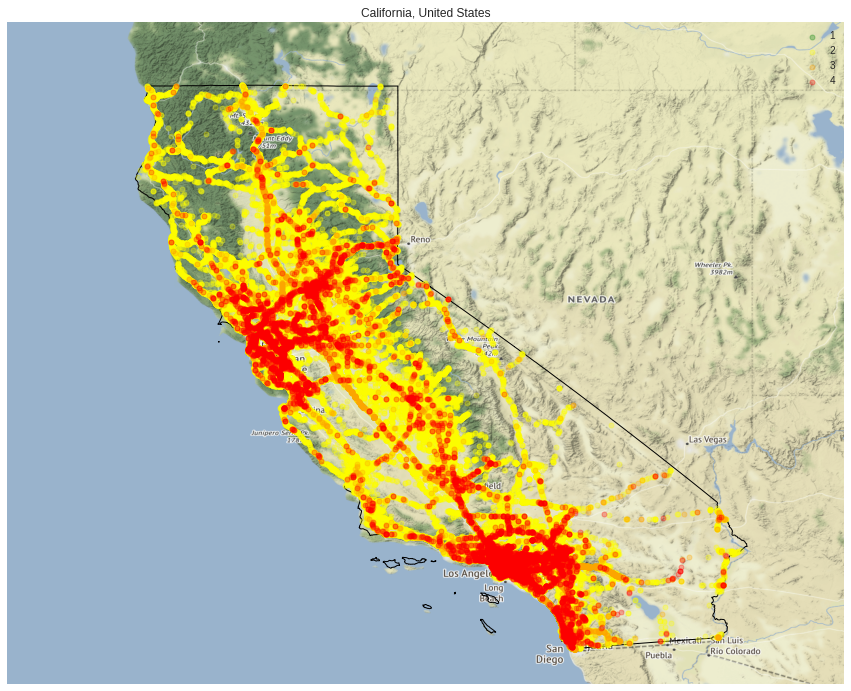

In [244]:
get_map(some_data_geo, 'California', 'CA')

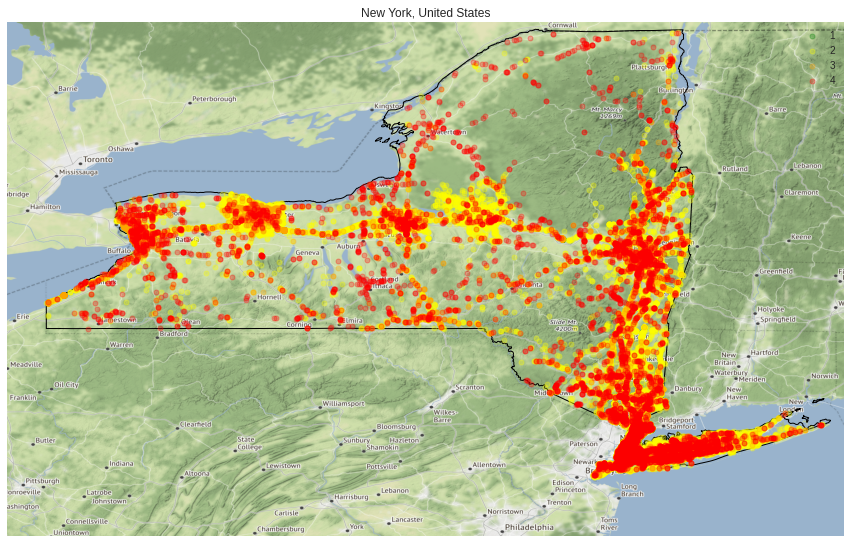

In [243]:
state_name='New York'
st_abr = 'NY'
loc = ctx.Place('New York State') 
fig, ax = plt.subplots(figsize=(15, 15))
    #Bring in Base Map
ctx.plot_map(loc, ax=ax)
    #Bring in State Outline
states[states.NAME==state_name].plot(ax=ax, color= 'none', edgecolor='black')
    #Plot data from GeoFrames with different colors for Severity
ax=some_data_geo[(some_data_geo.State == st_abr)&(some_data_geo.Severity==1)].plot(ax=ax, marker='.', color='green', markersize=100,alpha=.3, label = '1')
ax=some_data_geo[(some_data_geo.State == st_abr)&(some_data_geo.Severity==2)].plot(ax=ax, marker='.', color='yellow', markersize=100,alpha=.3, label = '2')
ax=some_data_geo[(some_data_geo.State == st_abr)&(some_data_geo.Severity==3)].plot(ax=ax, marker='.', color='orange', markersize=100,alpha=.3, label = '3')
ax=some_data_geo[(some_data_geo.State == st_abr)&(some_data_geo.Severity==4)].plot(ax=ax, marker='.', color='red', markersize=100,alpha=.3, label = '4')
ax.legend()
plt.savefig(f'../data/{state_name} Map', format='png',bbox_inches='tight')

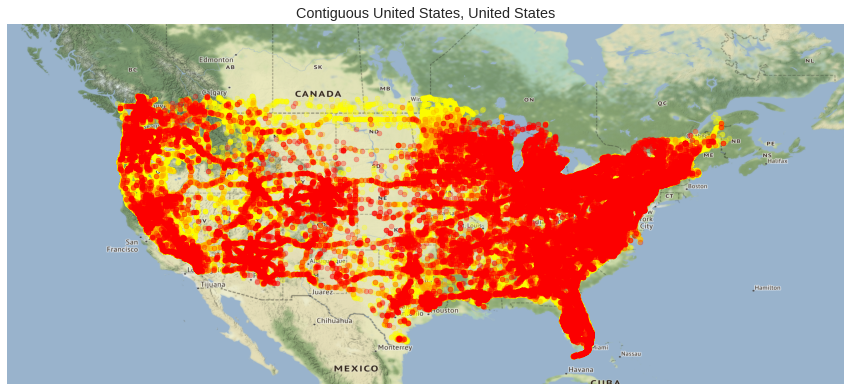

In [445]:
loc = ctx.Place('Contiguous United States of America') 
fig, ax = plt.subplots(figsize=(15, 15))
    #Bring in Base Map
ctx.plot_map(loc, ax=ax)
ax=some_data_geo[(some_data_geo.Severity==1)].plot(ax=ax, marker='.', color='green', markersize=100,alpha=.3, legend = '1')
ax=some_data_geo[(some_data_geo.Severity==2)].plot(ax=ax, marker='.', color='yellow', markersize=100,alpha=.3, legend = '2')
ax=some_data_geo[(some_data_geo.Severity==3)].plot(ax=ax, marker='.', color='orange', markersize=100,alpha=.3, legend = '3')
ax=some_data_geo[(some_data_geo.Severity==4)].plot(ax=ax, marker='.', color='red', markersize=100,alpha=.3, legend = '4')
plt.savefig(f'../data/USA Map', format='png',bbox_inches='tight')

In [28]:
this_map = folium.Map(prefer_canvas=True)

def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    if point.Severity == 1:
        colors = '#00ff00'
    elif point.Severity == 2:
        colors = '#ffff00'
    elif point.Severity == 3:
        colors = '#ffa500'
    else:
        colors = '#ff0000'
    folium.CircleMarker(location=[point.Start_Lat, point.Start_Lng],radius=2, weight=5,color=colors).add_to(this_map)

#use df.apply(,axis=1) to "iterate" through every row in your dataframe
some_data_df.apply(plotDot, axis = 1)


#Set the zoom to the maximum possible
this_map.fit_bounds(this_map.get_bounds())

#Save the map to an HTML file
this_map.save('../data/simple_dot_plot.html')


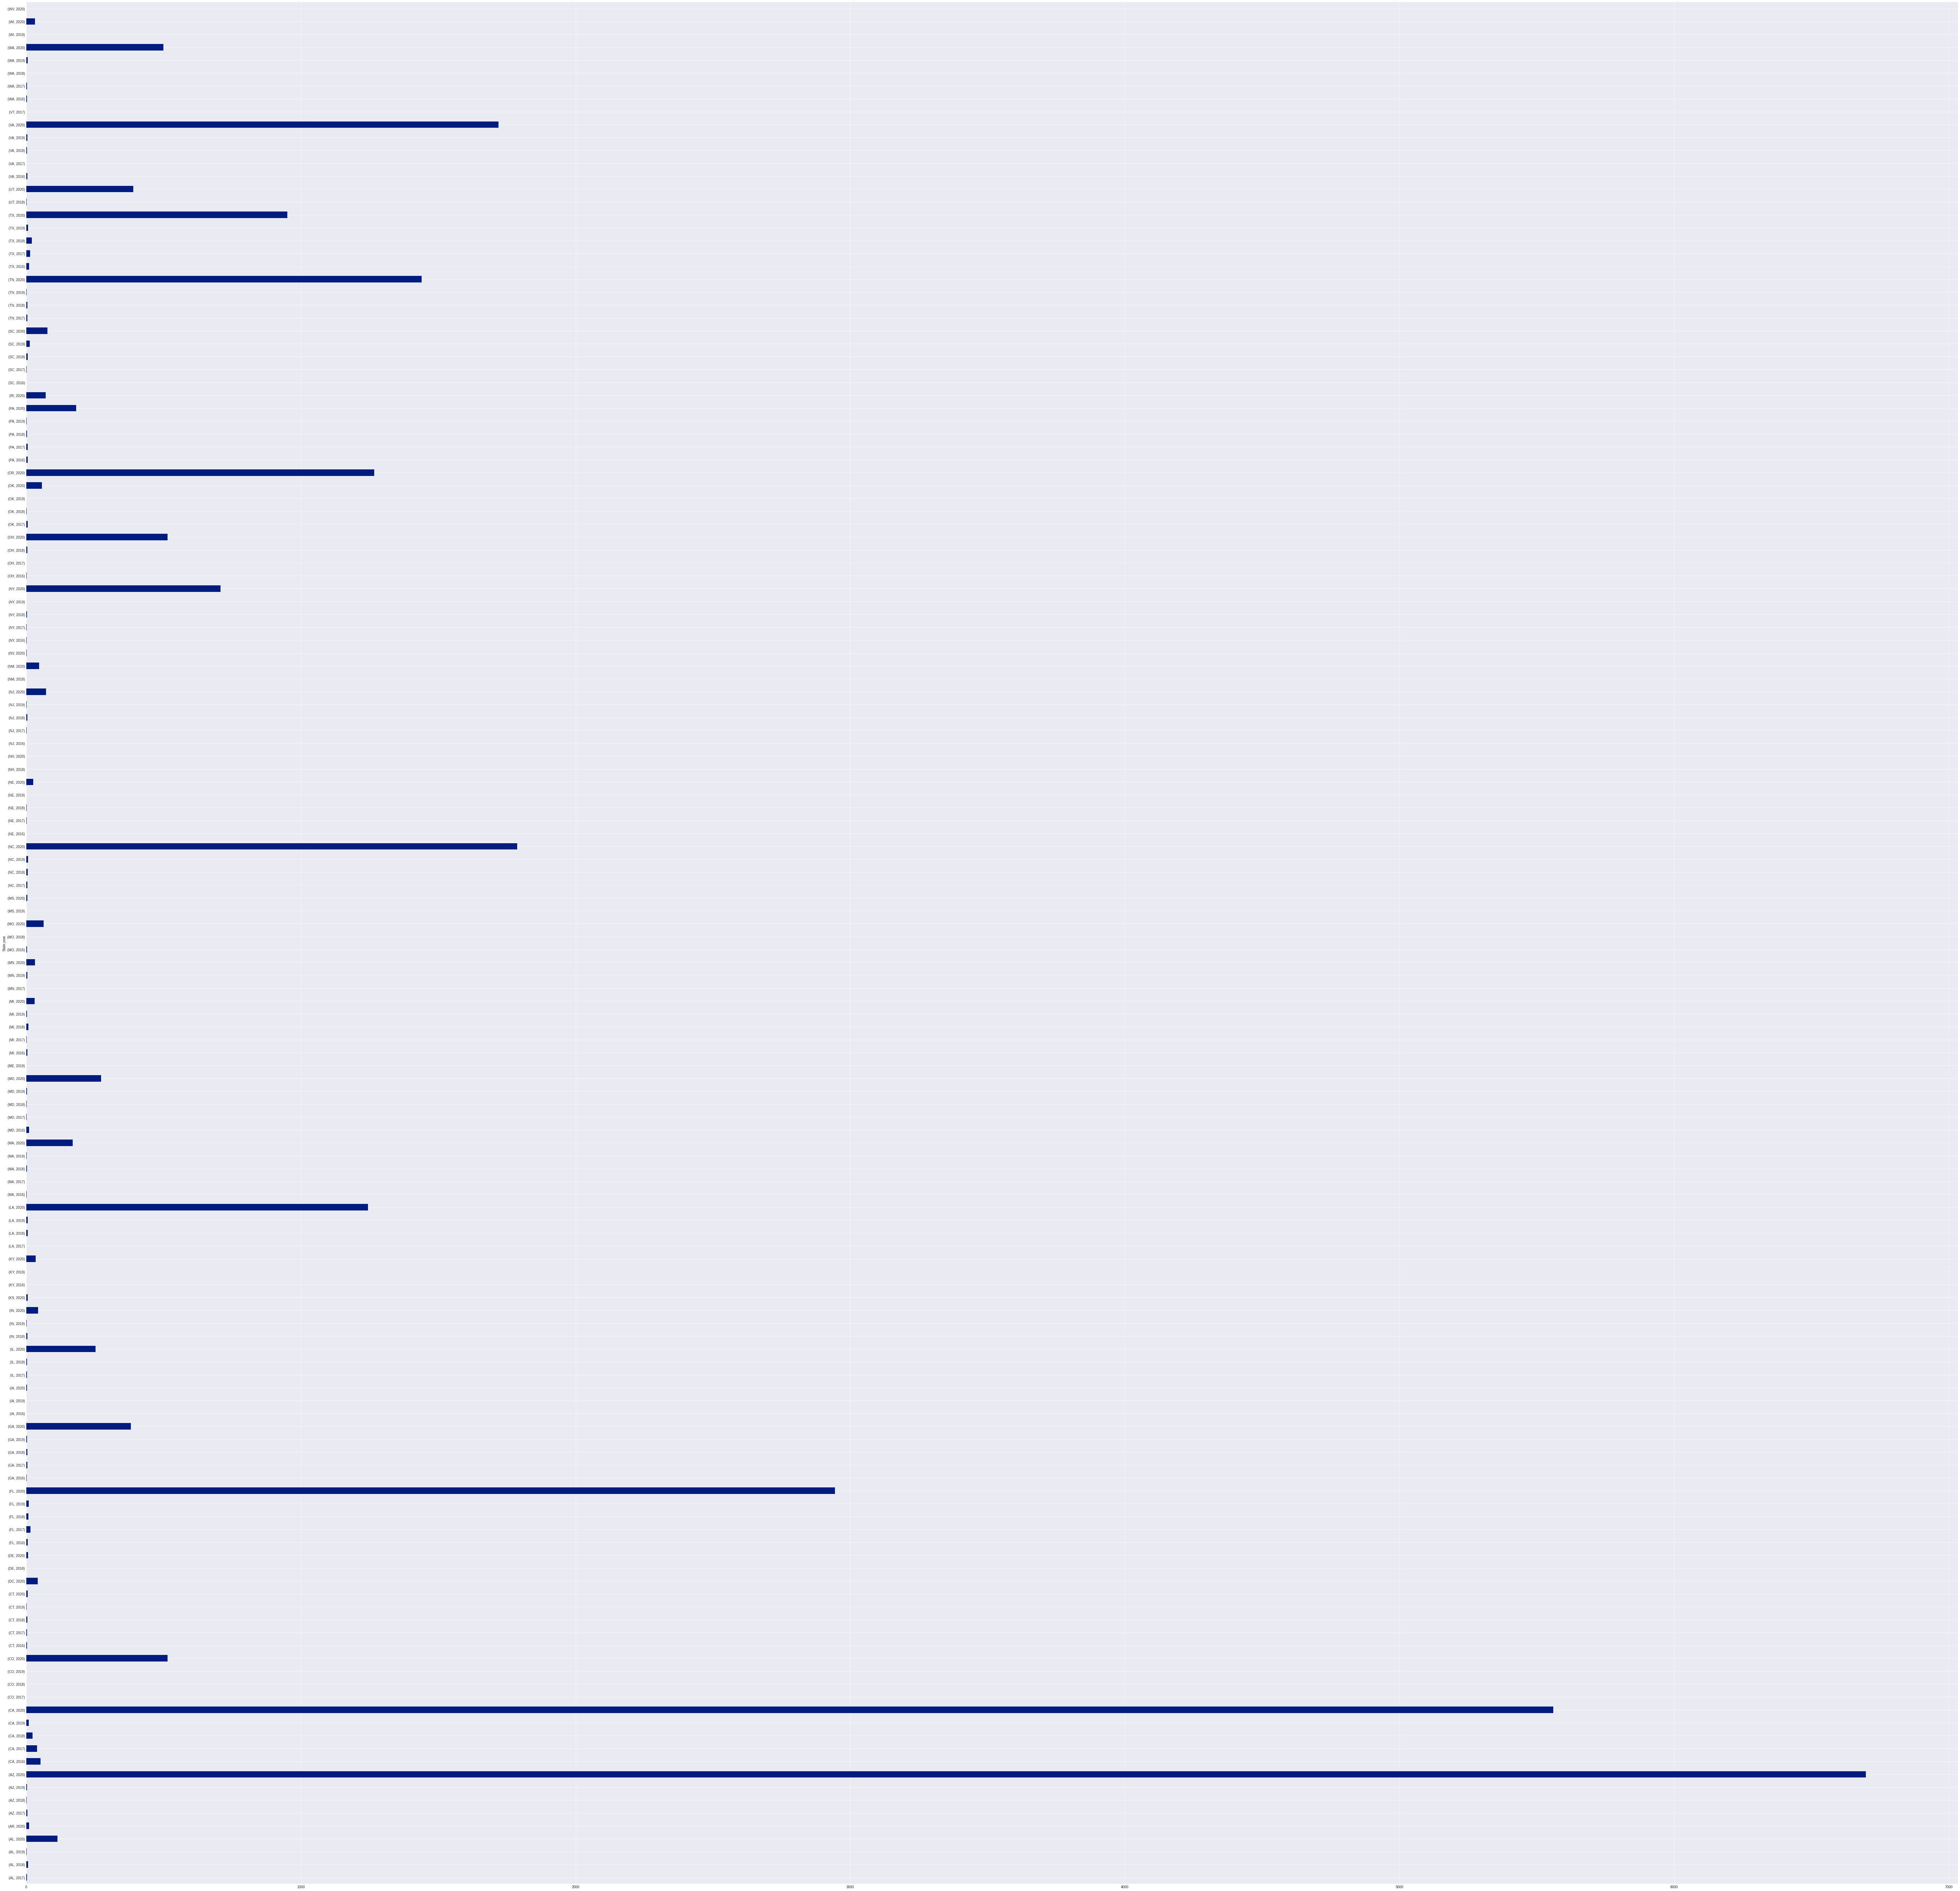

In [161]:
fig, ax = plt.subplots(figsize=(100, 100))
ax = some_data_df[(some_data_df.Severity==1)].groupby([some_data_df.State,some_data_df.year]).count()['ID'].plot.barh()
plt.savefig(f'../data/Severity1', format='png',bbox_inches='tight')

In [196]:
te = some_data_df[(some_data_df.Severity==1)].groupby([some_data_df.State,some_data_df.year]).count()

In [208]:
counter = 0
states = []
for val in te.index:
    if val[1] == 2020:
        counter += 1
        print(f'{val} = {te.loc[val].ID} {counter}')
        states.append(val[0])

('AL', 2020) = 114 1
('AR', 2020) = 11 2
('AZ', 2020) = 6698 3
('CA', 2020) = 5560 4
('CO', 2020) = 514 5
('CT', 2020) = 5 6
('DC', 2020) = 42 7
('DE', 2020) = 7 8
('FL', 2020) = 2945 9
('GA', 2020) = 381 10
('IA', 2020) = 3 11
('IL', 2020) = 252 12
('IN', 2020) = 43 13
('KS', 2020) = 5 14
('KY', 2020) = 34 15
('LA', 2020) = 1244 16
('MA', 2020) = 169 17
('MD', 2020) = 273 18
('MI', 2020) = 30 19
('MN', 2020) = 32 20
('MO', 2020) = 63 21
('MS', 2020) = 4 22
('NC', 2020) = 1788 23
('NE', 2020) = 26 24
('NH', 2020) = 1 25
('NJ', 2020) = 72 26
('NM', 2020) = 47 27
('NV', 2020) = 2 28
('NY', 2020) = 708 29
('OH', 2020) = 514 30
('OK', 2020) = 57 31
('OR', 2020) = 1267 32
('PA', 2020) = 182 33
('RI', 2020) = 71 34
('SC', 2020) = 77 35
('TN', 2020) = 1440 36
('TX', 2020) = 951 37
('UT', 2020) = 390 38
('VA', 2020) = 1720 39
('WA', 2020) = 500 40
('WI', 2020) = 32 41
('WV', 2020) = 1 42


In [207]:
some_data_df.groupby(some_data_df.State).count().index

Index(['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'IA', 'ID',
       'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS',
       'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR',
       'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV',
       'WY'],
      dtype='object', name='State')

In [209]:
states

['AL',
 'AR',
 'AZ',
 'CA',
 'CO',
 'CT',
 'DC',
 'DE',
 'FL',
 'GA',
 'IA',
 'IL',
 'IN',
 'KS',
 'KY',
 'LA',
 'MA',
 'MD',
 'MI',
 'MN',
 'MO',
 'MS',
 'NC',
 'NE',
 'NH',
 'NJ',
 'NM',
 'NV',
 'NY',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'TN',
 'TX',
 'UT',
 'VA',
 'WA',
 'WI',
 'WV']

In [210]:
for state in some_data_df.groupby(some_data_df.State).count().index:
    if state not in states:
        print(state)

ID
ME
MT
ND
SD
VT
WY


In [223]:
some_data_df.groupby([some_data_df.State,some_data_df.year]).count().loc["ID"]

ID  Severity  Start_Time  Start_Lat  Start_Lng  City  County  Zipcode  \
year                                                                            
2016   419       419         419        419        419   419     419      419   
2017   346       346         346        346        346   346     346      346   
2018   389       389         389        389        389   389     389      389   
2019   540       540         540        540        540   540     540      540   
2020  2471      2471        2471       2471       2471  2471    2471     2471   

      Sunrise_Sunset  Civil_Twilight  geometry  month  hour  
year                                                         
2016             419             419       419    419   419  
2017             346             346       346    346   346  
2018             389             389       389    389   389  
2019             540             540       540    540   540  
2020            2471            2471      2471   2471  2471

In [232]:
test = some_data_df[some_data_df.State=='WY'].groupby(some_data_df.Severity).count().copy()

In [234]:
test[1] = 0

In [235]:
test

ID  Severity  Start_Time  Start_Lat  Start_Lng  City  County  \
Severity                                                                  
2         118       118         118        118        118   118     118   
3         112       112         112        112        112   112     112   
4         189       189         189        189        189   189     189   

          State  Zipcode  Sunrise_Sunset  Civil_Twilight  geometry  year  \
Severity                                                                   
2           118      118             118             118       118   118   
3           112      112             112             112       112   112   
4           189      189             189             189       189   189   

          month  hour  1  
Severity                  
2           118   118  0  
3           112   112  0  
4           189   189  0

In [269]:
stats.mannwhitneyu(some_data_df[some_data_df['State']=='NY']['Severity'], some_data_df[some_data_df['State']=='CA']['Severity'], alternative="greater")

MannwhitneyuResult(statistic=52785542558.0, pvalue=0.0)

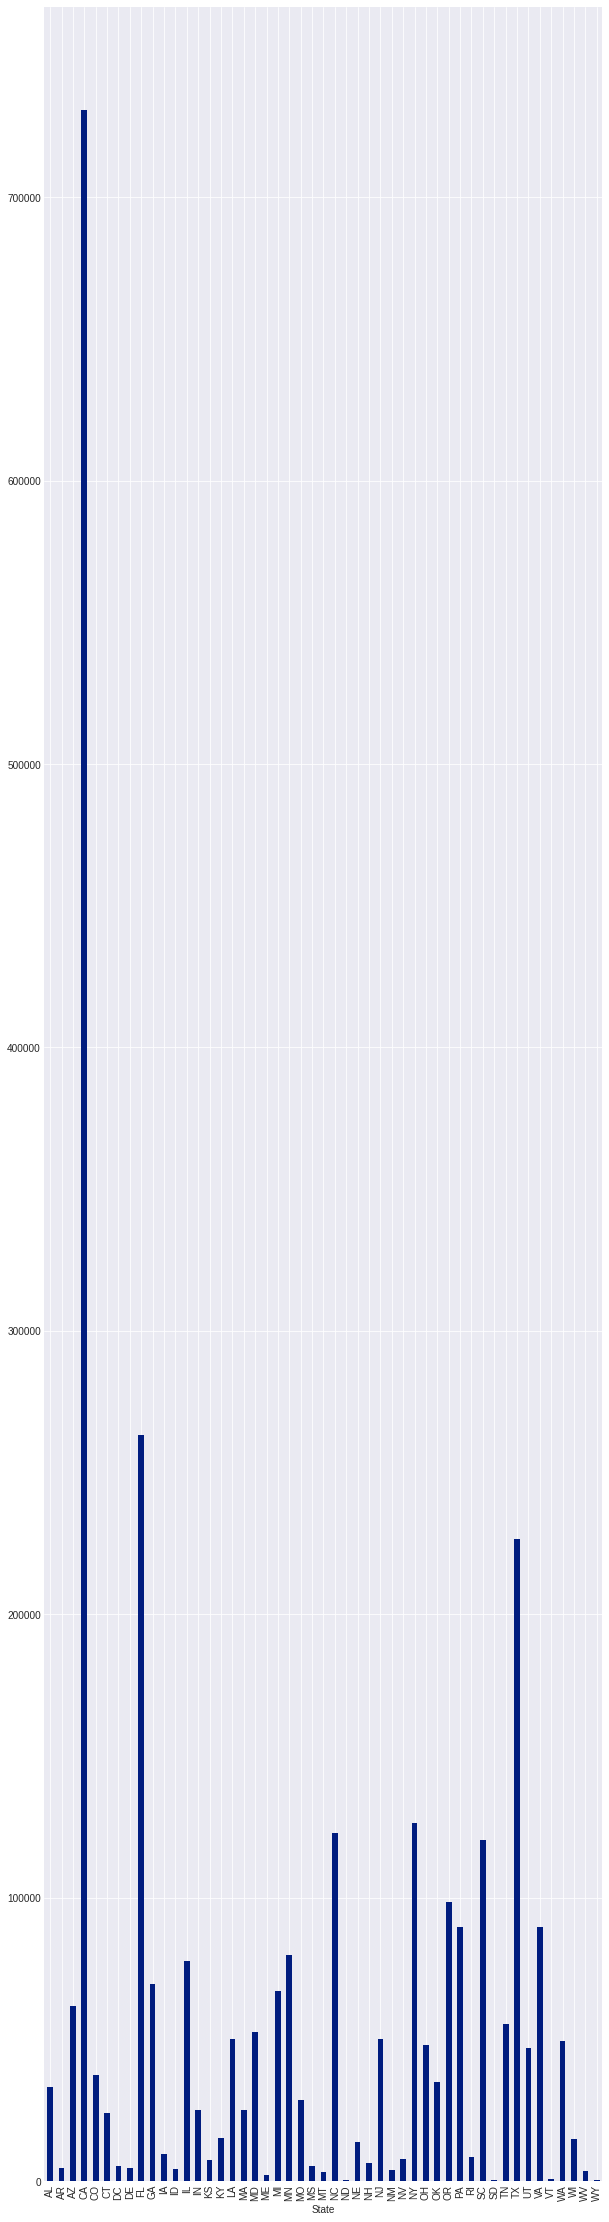

In [291]:
some_data_df.groupby(some_data_df.State).count().sort_values(by='State')['ID'].plot.bar(figsize=(10,40))
plt.savefig('../data/all_states', format='jpeg', bbox_inches='tight' )

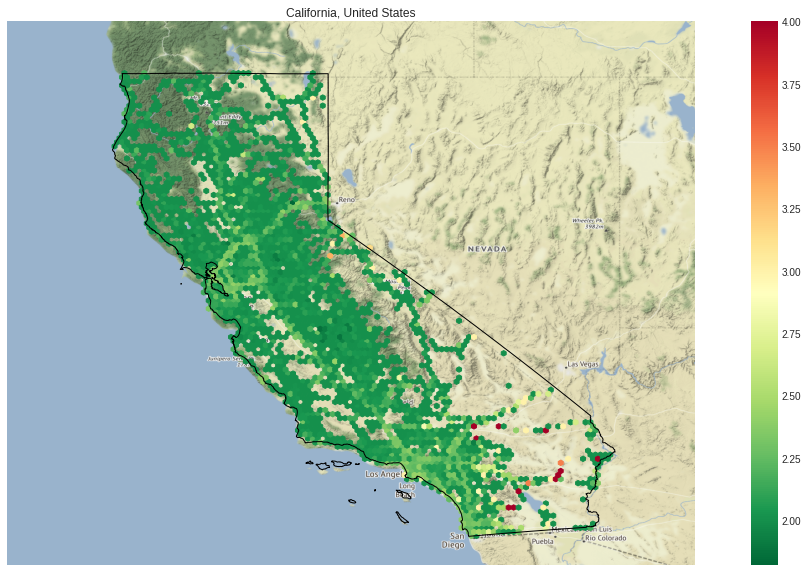

In [465]:
loc = ctx.Place('California') 
fig, ax = plt.subplots(figsize=(20, 10))
    #Bring in Base Map
ctx.plot_map(loc, ax=ax)
plt.hexbin(some_data_df[(some_data_df.State=='CA')].Start_Lng, some_data_df[(some_data_df.State=='CA')].Start_Lat, C=some_data_df[(some_data_df.State=='CA')].Severity, cmap='RdYlGn_r')
states[states.NAME=='California'].plot(ax=ax, color= 'none', edgecolor='black')
plt.colorbar()
plt.savefig(f'../data/California_Hex2', format='svg', dpi=600,bbox_inches='tight')
plt.show()

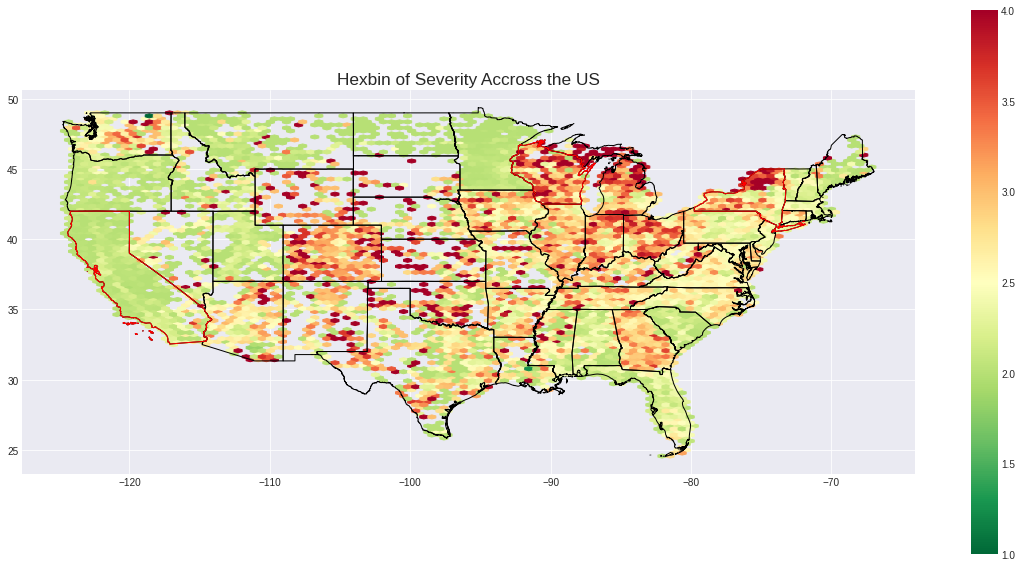

In [467]:
loc = ctx.Place('Contiguous United States of America') 
fig, ax = plt.subplots(figsize=(20, 10))
    #Bring in Base Map
# ctx.plot_map(loc, ax=ax, bbox=loc.bbox)
plt.hexbin(some_data_df.Start_Lng, some_data_df.Start_Lat, C=some_data_df.Severity, cmap='RdYlGn_r')
states[(states.NAME!='Puerto Rico')&(states.NAME!='Commonwealth of the Northern Mariana Islands')&(states.NAME!='Alaska')&(states.NAME!='Guam')&(states.NAME!='American Samoa')&(states.NAME!='United States Virgin Islands')&(states.NAME!='Hawaii')].plot(ax=ax, color= 'none', edgecolor='black')
states[states.NAME=='Wisconsin'].plot(ax=ax, color= 'none', edgecolor='red')
states[states.NAME=='California'].plot(ax=ax, color= 'none', edgecolor='red')
states[states.NAME=='New York'].plot(ax=ax, color= 'none', edgecolor='red')
plt.title("Hexbin of Severity Accross the US", size="xx-large")
plt.colorbar()
plt.savefig(f'../data/US_hex', format='svg', dpi=600,bbox_inches='tight')
plt.show()

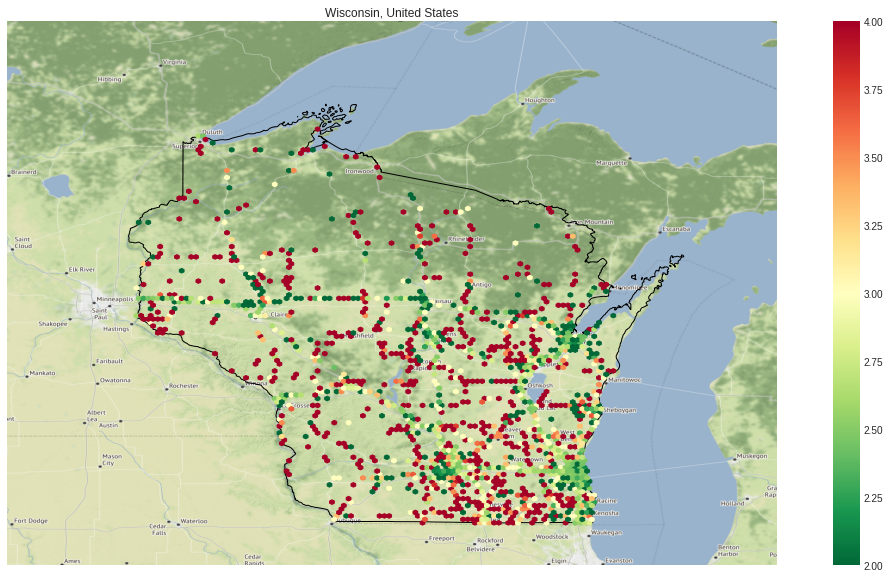

In [468]:
loc = ctx.Place('Wisconsin') 
fig, ax = plt.subplots(figsize=(20, 10))
    #Bring in Base Map
ctx.plot_map(loc, ax=ax)
states[states.NAME=='Wisconsin'].plot(ax=ax, color= 'none', edgecolor='black')
plt.hexbin(some_data_df[(some_data_df.State=='WI')].Start_Lng, some_data_df[(some_data_df.State=='WI')].Start_Lat, C=some_data_df[(some_data_df.State=='WI')].Severity, cmap='RdYlGn_r')
plt.colorbar()
plt.savefig(f'../data/Wisconsin_Hex', format='svg', dpi=600,bbox_inches='tight')
plt.show()

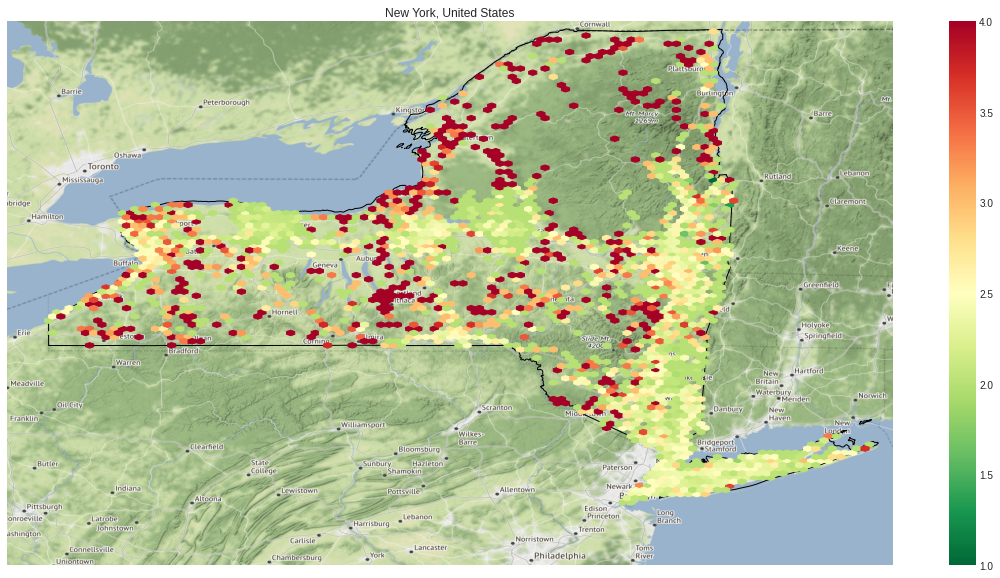

In [469]:
loc = ctx.Place('New York State') 
fig, ax = plt.subplots(figsize=(20, 10))
    #Bring in Base Map
ctx.plot_map(loc, ax=ax)
states[states.NAME=='New York'].plot(ax=ax, color= 'none', edgecolor='black')
plt.hexbin(some_data_df[(some_data_df.State=='NY')].Start_Lng, some_data_df[(some_data_df.State=='NY')].Start_Lat, C=some_data_df[(some_data_df.State=='NY')].Severity, cmap='RdYlGn_r')
plt.colorbar()
plt.savefig(f'../data/NewYork', format='svg', dpi=600,bbox_inches='tight')
plt.show()

TypeError: Must set either crs or epsg for output.

In [388]:
some_WM = some_data_geo.to_crs(crs=4326,epsg=3857)

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

In [393]:
some_data_geo.crs = "EPSG:4326"

some

In [395]:
some_data_geo.crs

'EPSG:4326'

In [396]:
some_WM = some_data_geo.to_crs(epsg=3857)

RuntimeError: b'no arguments in initialization list'

In [422]:
states.info

<bound method DataFrame.info of    STATEFP   STATENS     AFFGEOID GEOID STUSPS  \
0       28  01779790  0400000US28    28     MS   
1       37  01027616  0400000US37    37     NC   
2       40  01102857  0400000US40    40     OK   
3       51  01779803  0400000US51    51     VA   
4       54  01779805  0400000US54    54     WV   
5       22  01629543  0400000US22    22     LA   
6       26  01779789  0400000US26    26     MI   
7       25  00606926  0400000US25    25     MA   
8       16  01779783  0400000US16    16     ID   
9       12  00294478  0400000US12    12     FL   
10      31  01779792  0400000US31    31     NE   
11      53  01779804  0400000US53    53     WA   
12      35  00897535  0400000US35    35     NM   
13      72  01779808  0400000US72    72     PR   
14      46  01785534  0400000US46    46     SD   
15      48  01779801  0400000US48    48     TX   
16      06  01779778  0400000US06    06     CA   
17      01  01779775  0400000US01    01     AL   
18      13  017053

In [415]:
ctx.sources

<module 'contextily.tile_providers' from '/home/stingl/anaconda3/lib/python3.8/site-packages/contextily/tile_providers.py'>

In [435]:
states[(states.NAME!='Commonwealth of the Northern Mariana Islands')&(states.NAME!='Alaska')&(states.NAME!='Guam')&(states.NAME!='American Samoa')&(states.NAME!='United States Virgin Islands')&(states.NAME!='Hawaii')]

STATEFP   STATENS     AFFGEOID GEOID STUSPS                  NAME LSAD  \
0       28  01779790  0400000US28    28     MS           Mississippi   00   
1       37  01027616  0400000US37    37     NC        North Carolina   00   
2       40  01102857  0400000US40    40     OK              Oklahoma   00   
3       51  01779803  0400000US51    51     VA              Virginia   00   
4       54  01779805  0400000US54    54     WV         West Virginia   00   
5       22  01629543  0400000US22    22     LA             Louisiana   00   
6       26  01779789  0400000US26    26     MI              Michigan   00   
7       25  00606926  0400000US25    25     MA         Massachusetts   00   
8       16  01779783  0400000US16    16     ID                 Idaho   00   
9       12  00294478  0400000US12    12     FL               Florida   00   
10      31  01779792  0400000US31    31     NE              Nebraska   00   
11      53  01779804  0400000US53    53     WA            Washington   00   
12      35  00897535  0400000US35    35     NM            New Mexico   00   
13      72  01779808  0400000US72    72     PR           Puerto Rico   00   
14      46  01785534  0400000US46    46     SD          South Dakota   00   
15      48  01779801  0400000US48    48     TX                 Texas   00   
16      06  01779778  0400000US06    06     CA            California   00   
17      01  01779775  0400000US01    01     AL               Alabama   00   
18      13  01705317  0400000US13    13     GA               Georgia   00   
19      42  01779798  0400000US42    42     PA          Pennsylvania   00   
20      29  01779791  0400000US29    29     MO              Missouri   00   
21      08  01779779  0400000US08    08     CO              Colorado   00   
22      49  01455989  0400000US49    49     UT                  Utah   00   
23      47  01325873  0400000US47    47     TN             Tennessee   00   
24      56  01779807  0400000US56    56     WY               Wyoming   00   
25      36  01779796  0400000US36    36     NY              New York   00   
26      20  00481813  0400000US20    20     KS                Kansas   00   
28      32  01779793  0400000US32    32     NV                Nevada   00   
29      17  01779784  0400000US17    17     IL              Illinois   00   
30      50  01779802  0400000US50    50     VT               Vermont   00   
31      30  00767982  0400000US30    30     MT               Montana   00   
32      19  01779785  0400000US19    19     IA                  Iowa   00   
33      45  01779799  0400000US45    45     SC        South Carolina   00   
34      33  01779794  0400000US33    33     NH         New Hampshire   00   
35      04  01779777  0400000US04    04     AZ               Arizona   00   
36      11  01702382  0400000US11    11     DC  District of Columbia   00   
39      34  01779795  0400000US34    34     NJ            New Jersey   00   
40      24  01714934  0400000US24    24     MD              Maryland   00   
41      23  01779787  0400000US23    23     ME                 Maine   00   
43      10  01779781  0400000US10    10     DE              Delaware   00   
46      44  01219835  0400000US44    44     RI          Rhode Island   00   
47      21  01779786  0400000US21    21     KY              Kentucky   00   
48      39  01085497  0400000US39    39     OH                  Ohio   00   
49      55  01779806  0400000US55    55     WI             Wisconsin   00   
50      41  01155107  0400000US41    41     OR                Oregon   00   
51      38  01779797  0400000US38    38     ND          North Dakota   00   
52      05  00068085  0400000US05    05     AR              Arkansas   00   
53      18  00448508  0400000US18    18     IN               Indiana   00   
54      27  00662849  0400000US27    27     MN             Minnesota   00   
55      09  01779780  0400000US09    09     CT           Connecticut   00   

           ALAND        AWATER  \
0   121533519481    3926919758   
1   125

In [440]:
loc = ctx.Place('Contiguous United States of America')

In [441]:
loc.bbox

[-125.0840939, 24.2520071, -66.8854156, 49.3844722]

In [471]:
some_data_df[some_data_df.Sunrise_Sunset=='Day']

ID  Severity          Start_Time  Start_Lat   Start_Lng  \
0              A-1         2 2019-05-21 08:29:55  34.808868  -82.269157   
1              A-2         2 2019-10-07 17:43:09  35.090080  -80.745560   
3              A-4         2 2018-04-17 16:51:23  39.110390 -119.773781   
4              A-5         3 2016-08-31 17:40:49  26.102942  -80.265091   
5              A-6         3 2018-10-17 16:40:36  35.348240  -80.847221   
...            ...       ...                 ...        ...         ...   
2906601  A-2906602         3 2018-03-12 08:24:41  26.033428  -80.164490   
2906604  A-2906605         2 2020-10-02 08:42:20  26.392847  -80.095268   
2906605  A-2906606         2 2018-06-28 08:49:01  29.813824  -95.399437   
2906607  A-2906608         2 2020-11-23 12:52:00  25.702200  -80.335556   
2906609  A-2906610         2 2018-03-26 13:35:03  38.831749 -104.748161   

                     City       County State     Zipcode Sunrise_Sunset  \
0              Greenville   Greenville    SC  29607-6027            Day   
1               Charlotte  Mecklenburg    NC  28270-8560            Day   
3             Carson City      Douglas    NV       89705            Day   
4         Fort Lauderdale      Broward    FL       33324            Day   
5               Charlotte  Mecklenburg    NC       28269            Day   
...                   ...          ...   ...         ...            ...   
2906601         Hollywood      Broward    FL       33020            Day   
2906604        Boca Raton   Palm Beach    FL       33431            Day   
2906605           Houston       Harris    TX  77018-8433            Day   
2906607             Miami   Miami-Dade    FL  33173-3512            Day   
2906609  Colorado Springs      El Paso    CO       80916            Day   

        Civil_Twilight                     geometry  year  month  hour  
0                  Day   POINT (-82.26916 34.80887)  2019      5     8  
1                  Day   POINT (-80.74556 35.09008)  2019     10    17  
3                  Day  POINT (-119.77378 39.11039)  2018      4    16  
4                  Day   POINT (-80.26509 26.10294)  2016      8    17  
5                  Day   POINT (-80.84722 35.34824)  2018     10    16  
...                ...                          ...   ...    ...   ...  
2906601            Day   POINT (-80.16449 26.03343)  2018      3     8  
2906604            Day   POINT (-80.09527 26.39285)  2020     10     8  
2906605            Day   POINT (-95.39944 29.81382)  2018      6     8  
2906607            Day   POINT (-80.33556 25.70220)  2020     11    12  
2906609            Day  POINT (-104.74816 38.83175)  2018      3    13  

[1941068 rows x 15 columns]

In [472]:
some_data_df[some_data_df.Sunrise_Sunset=='Night']

ID  Severity          Start_Time  Start_Lat   Start_Lng  \
2              A-3         2 2020-12-13 21:53:00  37.145730 -121.985052   
7              A-8         2 2019-12-21 23:59:00  34.034017 -118.026972   
11            A-12         2 2020-12-17 16:38:09  40.912210  -73.875099   
26            A-27         3 2017-09-07 20:37:46  32.871090  -80.010628   
28            A-29         2 2020-06-15 23:38:00  33.774159 -118.049783   
...            ...       ...                 ...        ...         ...   
2906593  A-2906594         2 2020-12-10 02:14:00  30.288995  -82.859219   
2906602  A-2906603         2 2020-10-31 03:49:00  30.420856  -97.624067   
2906603  A-2906604         2 2016-12-19 06:34:56  38.993397  -77.026680   
2906606  A-2906607         2 2019-01-10 02:01:01  34.068890 -117.342010   
2906608  A-2906609         2 2019-12-29 22:38:00  40.660140 -111.952460   

                     City          County State     Zipcode Sunrise_Sunset  \
2               Los Gatos     Santa Clara    CA       95033          Night   
7                Whittier     Los Angeles    CA       90601          Night   
11                Yonkers     Westchester    NY       10704          Night   
26       North Charleston      Charleston    SC       29418          Night   
28             Seal Beach          Orange    CA       90740          Night   
...                   ...             ...   ...         ...            ...   
2906593          Live Oak        Suwannee    FL       32060          Night   
2906602      Pflugerville          Travis    TX  78660-8022          Night   
2906603     Silver Spring      Montgomery    MD       20910          Night   
2906606            Colton  San Bernardino    CA       92324          Night   
2906608    Salt Lake City       Salt Lake    UT       84129          Night   

        Civil_Twilight                     geometry  year  month  hour  
2                Night  POINT (-121.98505 37.14573)  2020     12    21  
7                Night  POINT (-118.02697 34.03402)  2019     12    23  
11                 Day   POINT (-73.87510 40.91221)  2020     12    16  
26               Night   POINT (-80.01063 32.87109)  2017      9    20  
28               Night  POINT (-118.04978 33.77416)  2020      6    23  
...                ...                          ...   ...    ...   ...  
2906593          Night   POINT (-82.85922 30.28899)  2020     12     2  
2906602          Night   POINT (-97.62407 30.42086)  2020     10     3  
2906603          Night   POINT (-77.02668 38.99340)  2016     12     6  
2906606          Night  POINT (-117.34201 34.06889)  2019      1     2  
2906608          Night  POINT (-111.95246 40.66014)  2019     12    22  

[965432 rows x 15 columns]

In [475]:
stats.mannwhitneyu(some_data_df[some_data_df.Sunrise_Sunset=='Day']['Severity'],some_data_df[some_data_df.Sunrise_Sunset=='Night']['Severity'],alternative='greater')

MannwhitneyuResult(statistic=954248210841.0, pvalue=1.2801413066485558e-241)

In [476]:
some_data_df[some_data_df.Sunrise_Sunset=='Day']['Severity']

0          2
1          2
3          2
4          3
5          3
          ..
2906601    3
2906604    2
2906605    2
2906607    2
2906609    2
Name: Severity, Length: 1941068, dtype: int64

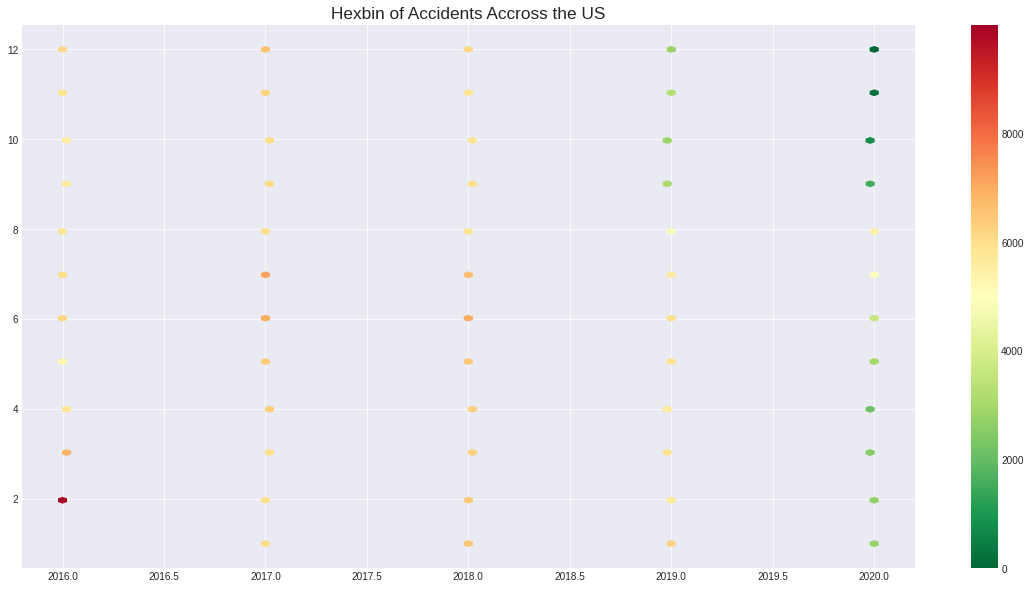

In [77]:
loc = ctx.Place('Contiguous United States of America') 
fig, ax = plt.subplots(figsize=(20, 10))
    #Bring in Base Map
# ctx.plot_map(loc, ax=ax, bbox=loc.bbox)
plt.hexbin(some_data_df.year, some_data_df.month, bins=10000,C=some_data_df.Severity, cmap='RdYlGn_r')
# states[(states.NAME!='Puerto Rico')&(states.NAME!='Commonwealth of the Northern Mariana Islands')&(states.NAME!='Alaska')&(states.NAME!='Guam')&(states.NAME!='American Samoa')&(states.NAME!='United States Virgin Islands')&(states.NAME!='Hawaii')].plot(ax=ax, color= 'none', edgecolor='black')
# states[states.NAME=='Wisconsin'].plot(ax=ax, color= 'none', edgecolor='red')
# states[states.NAME=='California'].plot(ax=ax, color= 'none', edgecolor='red')
# states[states.NAME=='New York'].plot(ax=ax, color= 'none', edgecolor='red')
plt.title("Hexbin of Accidents Accross the US", size="xx-large")
plt.colorbar()
# plt.savefig(f'../data/test', format='svg', dpi=600,bbox_inches='tight')
plt.show()

In [480]:
['AL',
 'AR',
 'CO',
 'CT',
 'DC',
 'DE',
 'GA',
 'IA',
 'IL',
 'IN',
 'KS',
 'KY',
 'MA',
 'MD',
 'MI',
 'MO',
 'MS',
 'NJ',
 'NM',
 'NV',
 'NY',
 'OH',
 'RI',
 'TX',
 'VA',
 'VT',
 'WA',
 'WI',
 'WV',
 'WY']

AttributeError: 'list' object has no attribute 'reshape'

In [ ]:
loc = ctx.Place('Contiguous United States of America') 
fig, ax = plt.subplots(figsize=(20, 10))
    #Bring in Base Map
# ctx.plot_map(loc, ax=ax, bbox=loc.bbox)
# plt.hexbin(some_data_df[some_data_df.Sunrise_Sunset=='Night'].Start_Lng, some_data_df[some_data_df.Sunrise_Sunset=='Night'].Start_Lat, C=some_data_df[some_data_df.Sunrise_Sunset=='Night'].Severity, cmap='RdYlGn_r')
states[(states.NAME!='Puerto Rico')&(states.NAME!='Commonwealth of the Northern Mariana Islands')&(states.NAME!='Alaska')&(states.NAME!='Guam')&(states.NAME!='American Samoa')&(states.NAME!='United States Virgin Islands')&(states.NAME!='Hawaii')].plot(ax=ax, color= 'none', edgecolor='black')
states[states.NAME=='Wisconsin'].plot(ax=ax, color= 'none', edgecolor='red')
states[states.NAME=='California'].plot(ax=ax, color= 'none', edgecolor='red')
states[states.NAME=='New York'].plot(ax=ax, color= 'none', edgecolor='red')
plt.title("Hexbin of Severity Accross the US", size="xx-large")
plt.colorbar()
plt.savefig(f'../data/NIGHT_HEX', format='svg', dpi=600,bbox_inches='tight')
plt.show()

In [481]:
some_data_df[some_data_df.State=='WI']['Severity'].mean()

2.6770059308746337

In [487]:
some_data_df.groupby(some_data_df.State)['Severity'].mean()[some_data_df.groupby(some_data_df.State)['Severity'].mean()>some_data_df['Severity'].mean()]

State
AL    2.292250
AR    2.382141
CO    2.609979
CT    2.515174
DC    2.412998
DE    2.488000
GA    2.633355
IA    2.571113
IL    2.470448
IN    2.531869
KS    2.479715
KY    2.471104
MA    2.376975
MD    2.512350
MI    2.453044
MO    2.532434
MS    2.406533
NJ    2.373043
NM    2.482507
NV    2.356119
NY    2.388552
OH    2.461075
PA    2.297420
RI    2.435771
SD    2.414747
TX    2.295107
VA    2.382481
VT    2.387387
WA    2.417410
WI    2.677006
WV    2.414791
WY    3.169451
Name: Severity, dtype: float64

In [483]:
some_data_df['Severity'].mean()

2.288648631911402

In [489]:
len(['AL',
 'AR',
 'CO',
 'CT',
 'DC',
 'DE',
 'GA',
 'IA',
 'IL',
 'IN',
 'KS',
 'KY',
 'MA',
 'MD',
 'MI',
 'MO',
 'MS',
 'NJ',
 'NM',
 'NV',
 'NY',
 'OH',
 'RI',
 'TX',
 'VA',
 'VT',
 'WA',
 'WI',
 'WV',
 'WY'])

30

In [20]:
plt.style.use('seaborn-darkgrid')
def State_Accidents_per_year(some_data_df, st_abr):
    #Make Plot
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(10, 4))
    # np.linspace()
    x=some_data_df[(some_data_df.Severity==1)&(some_data_df.State==st_abr)].groupby([some_data_df.year]).count().index
    y=some_data_df[(some_data_df.Severity==1)&(some_data_df.State==st_abr)].groupby([some_data_df.year]).count()['year']
    ax.plot(x,y,color='green',label='1')
    x=some_data_df[(some_data_df.Severity==2)&(some_data_df.State==st_abr)].groupby([some_data_df.year]).count().index
    y=some_data_df[(some_data_df.Severity==2)&(some_data_df.State==st_abr)].groupby([some_data_df.year]).count()['year']
    ax.plot(x,y,color='yellow',label='2')
    x=some_data_df[(some_data_df.Severity==3)&(some_data_df.State==st_abr)].groupby([some_data_df.year]).count().index
    y=some_data_df[(some_data_df.Severity==3)&(some_data_df.State==st_abr)].groupby([some_data_df.year]).count()['year']
    ax.plot(x,y,color='orange',label='3')
    x=some_data_df[(some_data_df.Severity==4)&(some_data_df.State==st_abr)].groupby([some_data_df.year]).count().index
    y=some_data_df[(some_data_df.Severity==4)&(some_data_df.State==st_abr)].groupby([some_data_df.year]).count()['year']
    ax.plot(x,y,color='red',label='4')
    plt.legend()
    plt.xticks([2016,2017,2018,2019,2020],['2016','2017','2018','2019','2020'])
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Accidents')
    plt.title(f'Number of Accidents in {st_abr} per Year by Severity')
    plt.savefig(f'../data/{st_abr}_Accidents_Severity_line', format='png',bbox_inches='tight')
    plt.close()

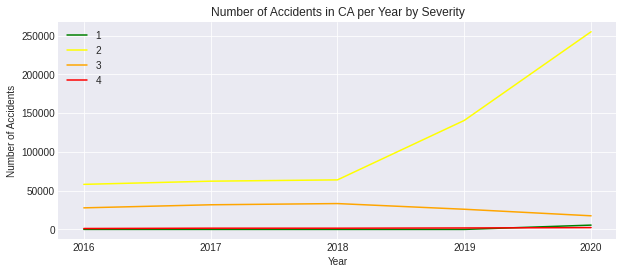

In [15]:
State_Accidents_per_year(some_data_df, 'CA')

In [21]:
for state in some_data_df['State'].groupby(some_data_df.State).count().index:
    State_Accidents_per_year(some_data_df, state)

In [19]:
some_data_df['State'].groupby(some_data_df.State).count().index

Index(['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'IA', 'ID',
       'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS',
       'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR',
       'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV',
       'WY'],
      dtype='object', name='State')

In [31]:
def state_hour_line(some_data_df, st_abr):
    #Make Plot
    fig, ax = plt.subplots(figsize=(10, 4))
    # np.linspace()
    x=some_data_df[(some_data_df.State == st_abr)&(some_data_df.Severity==1)].groupby([some_data_df.hour]).count().index
    y=some_data_df[(some_data_df.State == st_abr)&(some_data_df.Severity==1)].groupby([some_data_df.hour]).count()['hour']
    ax.plot(x,y,color='green',label='1')
    x=some_data_df[(some_data_df.State == st_abr)&(some_data_df.Severity==2)].groupby([some_data_df.hour]).count().index
    y=some_data_df[(some_data_df.State == st_abr)&(some_data_df.Severity==2)].groupby([some_data_df.hour]).count()['hour']
    ax.plot(x,y,color='yellow',label='2')
    x=some_data_df[(some_data_df.State == st_abr)&(some_data_df.Severity==3)].groupby([some_data_df.hour]).count().index
    y=some_data_df[(some_data_df.State == st_abr)&(some_data_df.Severity==3)].groupby([some_data_df.hour]).count()['hour']
    ax.plot(x,y,color='orange',label='3')
    x=some_data_df[(some_data_df.State == st_abr)&(some_data_df.Severity==4)].groupby([some_data_df.hour]).count().index
    y=some_data_df[(some_data_df.State == st_abr)&(some_data_df.Severity==4)].groupby([some_data_df.hour]).count()['hour']
    ax.plot(x,y,color='red',label='4')
    plt.legend()
    plt.xticks(np.linspace(0,24,24),['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])
    ax.set_xlabel('Hour')
    ax.set_ylabel('Number of Accidents')
    plt.title(f'Number of {st_abr} Accidents per Hour by Severity')
    plt.savefig(f'../data/{st_abr}_Accidents_Hour_line', format='png',bbox_inches='tight')
    plt.close()

In [32]:
for state in some_data_df['State'].groupby(some_data_df.State).count().index:
    state_hour_line(some_data_df, state)

In [33]:
def lazy(some_data_df):
#Make Plot
    fig, ax = plt.subplots(figsize=(10, 4))
    # np.linspace()
    x=some_data_df[(some_data_df.Severity==1)].groupby([some_data_df.hour]).count().index
    y=some_data_df[(some_data_df.Severity==1)].groupby([some_data_df.hour]).count()['hour']
    ax.plot(x,y,color='green',label='1')
    x=some_data_df[(some_data_df.Severity==2)].groupby([some_data_df.hour]).count().index
    y=some_data_df[(some_data_df.Severity==2)].groupby([some_data_df.hour]).count()['hour']
    ax.plot(x,y,color='yellow',label='2')
    x=some_data_df[(some_data_df.Severity==3)].groupby([some_data_df.hour]).count().index
    y=some_data_df[(some_data_df.Severity==3)].groupby([some_data_df.hour]).count()['hour']
    ax.plot(x,y,color='orange',label='3')
    x=some_data_df[(some_data_df.Severity==4)].groupby([some_data_df.hour]).count().index
    y=some_data_df[(some_data_df.Severity==4)].groupby([some_data_df.hour]).count()['hour']
    ax.plot(x,y,color='red',label='4')
    plt.legend()
    plt.xticks(np.linspace(0,24,24),['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])
    ax.set_xlabel('Hour')
    ax.set_ylabel('Number of Accidents')
    plt.title(f'Total Number of Accidents per Hour by Severity')
    plt.savefig(f'../data/Total_Accidents_Hour_line', format='png',bbox_inches='tight')
    plt.close()

In [34]:
lazy(some_data_df)

In [43]:
some_data_df.groupby([some_data_df.State,some_data_df.Severity]).count().loc['CA']

ID  Start_Time  Start_Lat  Start_Lng    City  County  Zipcode  \
Severity                                                                      
1           5683        5683       5683       5683    5683    5683     5674   
2         579890      579890     579890     579890  579884  579890   579629   
3         136563      136563     136563     136563  136563  136563   136528   
4           8608        8608       8608       8608    8608    8608     8603   

          Sunrise_Sunset  Civil_Twilight  geometry    year   month    hour  
Severity                                                                    
1                   5683            5683      5683    5683    5683    5683  
2                 579884          579884    579890  579890  579890  579890  
3                 136563          136563    136563  136563  136563  136563  
4                   8608            8608      8608    8608    8608    8608

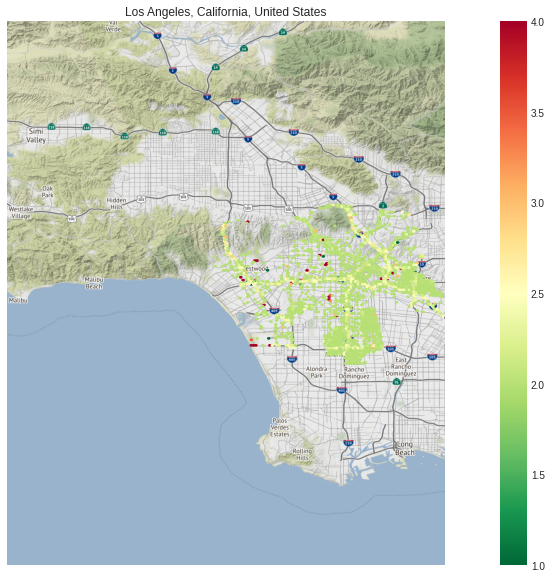

In [90]:
loc = ctx.Place('Los Angeles') 
fig, ax = plt.subplots(figsize=(20, 10))
    #Bring in Base Map

plt.hexbin(some_data_df[(some_data_df.City=='Los Angeles')].Start_Lng, some_data_df[(some_data_df.City=='Los Angeles')].Start_Lat,C=some_data_df[(some_data_df.City=='Los Angeles')].Severity, cmap='RdYlGn_r')
ctx.plot_map(loc, ax=ax)
plt.colorbar()
plt.show()

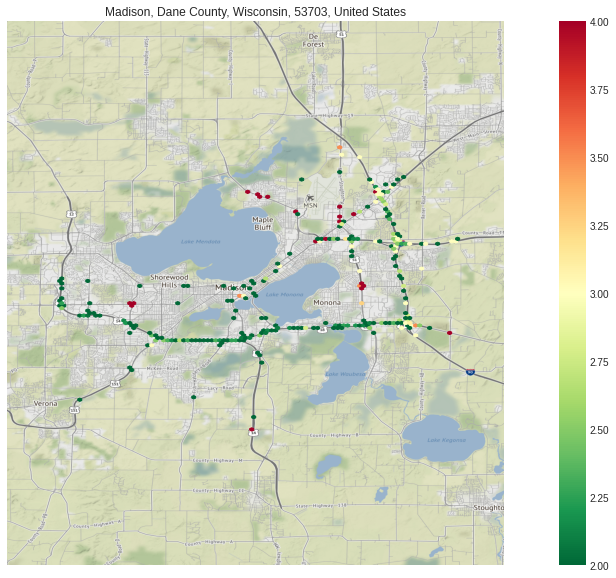

In [95]:
loc = ctx.Place('Madison') 
fig, ax = plt.subplots(figsize=(20, 10))
    #Bring in Base Map
plt.hexbin(some_data_df[(some_data_df.City=='Madison')&(some_data_df.State=='WI')].Start_Lng, some_data_df[(some_data_df.City=='Madison')&(some_data_df.State=='WI')].Start_Lat,C=some_data_df[(some_data_df.City=='Madison')&(some_data_df.State=='WI')].Severity, cmap='RdYlGn_r')
ctx.plot_map(loc, ax=ax)
plt.colorbar()
plt.show()

In [94]:
some_data_df[(some_data_df.City=='Madison')&(some_data_df.State=='WI')].count()

ID                1003
Severity          1003
Start_Time        1003
Start_Lat         1003
Start_Lng         1003
City              1003
County            1003
State             1003
Zipcode           1003
Sunrise_Sunset    1003
Civil_Twilight    1003
geometry          1003
year              1003
month             1003
hour              1003
dtype: int64

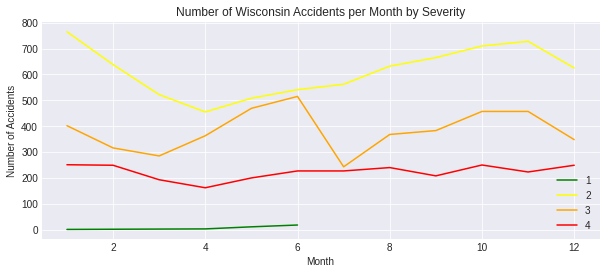

In [97]:
#Make Plot
fig, ax = plt.subplots(figsize=(10, 4))
# np.linspace()
x=some_data_df[(some_data_df.State == 'WI')&(some_data_df.Severity==1)].groupby([some_data_df.month]).count().index
y=some_data_df[(some_data_df.State == 'WI')&(some_data_df.Severity==1)].groupby([some_data_df.month]).count()['month']
ax.plot(x,y,color='green',label='1')
x=some_data_df[(some_data_df.State == 'WI')&(some_data_df.Severity==2)].groupby([some_data_df.month]).count().index
y=some_data_df[(some_data_df.State == 'WI')&(some_data_df.Severity==2)].groupby([some_data_df.month]).count()['month']
ax.plot(x,y,color='yellow',label='2')
x=some_data_df[(some_data_df.State == 'WI')&(some_data_df.Severity==3)].groupby([some_data_df.month]).count().index
y=some_data_df[(some_data_df.State == 'WI')&(some_data_df.Severity==3)].groupby([some_data_df.month]).count()['month']
ax.plot(x,y,color='orange',label='3')
x=some_data_df[(some_data_df.State == 'WI')&(some_data_df.Severity==4)].groupby([some_data_df.month]).count().index
y=some_data_df[(some_data_df.State == 'WI')&(some_data_df.Severity==4)].groupby([some_data_df.month]).count()['month']
ax.plot(x,y,color='red',label='4')
plt.legend()
# plt.xticks([2016,2017,2018,2019,2020],['2016','2017','2018','2019','2020'])
ax.set_xlabel('Month')
ax.set_ylabel('Number of Accidents')
plt.title('Number of Wisconsin Accidents per Month by Severity')
plt.show()

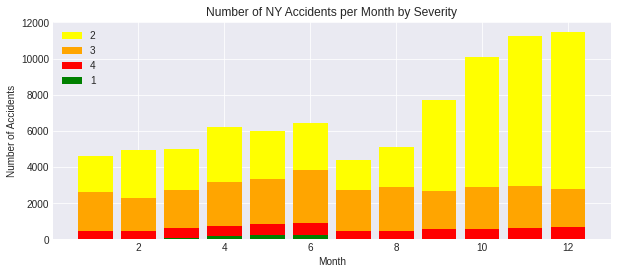

In [104]:
#Make Plot
fig, ax = plt.subplots(figsize=(10, 4))
# np.linspace()

x=some_data_df[(some_data_df.State == 'NY')&(some_data_df.Severity==2)].groupby([some_data_df.month]).count().index
y=some_data_df[(some_data_df.State == 'NY')&(some_data_df.Severity==2)].groupby([some_data_df.month]).count()['month']
ax.bar(x,y,color='yellow',label='2')
x=some_data_df[(some_data_df.State == 'NY')&(some_data_df.Severity==3)].groupby([some_data_df.month]).count().index
y=some_data_df[(some_data_df.State == 'NY')&(some_data_df.Severity==3)].groupby([some_data_df.month]).count()['month']
ax.bar(x,y,color='orange',label='3')
x=some_data_df[(some_data_df.State == 'NY')&(some_data_df.Severity==4)].groupby([some_data_df.month]).count().index
y=some_data_df[(some_data_df.State == 'NY')&(some_data_df.Severity==4)].groupby([some_data_df.month]).count()['month']
ax.bar(x,y,color='red',label='4')
x=some_data_df[(some_data_df.State == 'NY')&(some_data_df.Severity==1)].groupby([some_data_df.month]).count().index
y=some_data_df[(some_data_df.State == 'NY')&(some_data_df.Severity==1)].groupby([some_data_df.month]).count()['month']
ax.bar(x,y,color='green',label='1')
plt.legend()
# plt.xticks([2016,2017,2018,2019,2020],['2016','2017','2018','2019','2020'])
ax.set_xlabel('Month')
ax.set_ylabel('Number of Accidents')
plt.title('Number of NY Accidents per Month by Severity')
plt.show()

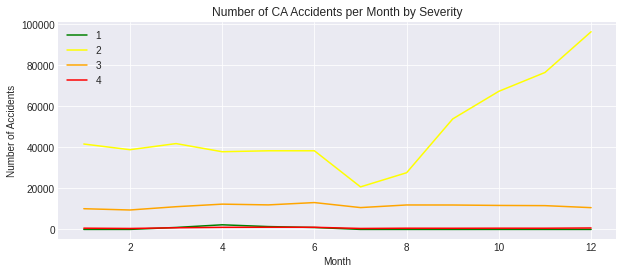

In [100]:
#Make Plot
fig, ax = plt.subplots(figsize=(10, 4))
# np.linspace()
x=some_data_df[(some_data_df.State == 'CA')&(some_data_df.Severity==1)].groupby([some_data_df.month]).count().index
y=some_data_df[(some_data_df.State == 'CA')&(some_data_df.Severity==1)].groupby([some_data_df.month]).count()['month']
ax.plot(x,y,color='green',label='1')
x=some_data_df[(some_data_df.State == 'CA')&(some_data_df.Severity==2)].groupby([some_data_df.month]).count().index
y=some_data_df[(some_data_df.State == 'CA')&(some_data_df.Severity==2)].groupby([some_data_df.month]).count()['month']
ax.plot(x,y,color='yellow',label='2')
x=some_data_df[(some_data_df.State == 'CA')&(some_data_df.Severity==3)].groupby([some_data_df.month]).count().index
y=some_data_df[(some_data_df.State == 'CA')&(some_data_df.Severity==3)].groupby([some_data_df.month]).count()['month']
ax.plot(x,y,color='orange',label='3')
x=some_data_df[(some_data_df.State == 'CA')&(some_data_df.Severity==4)].groupby([some_data_df.month]).count().index
y=some_data_df[(some_data_df.State == 'CA')&(some_data_df.Severity==4)].groupby([some_data_df.month]).count()['month']
ax.plot(x,y,color='red',label='4')
plt.legend()
# plt.xticks([2016,2017,2018,2019,2020],['2016','2017','2018','2019','2020'])
ax.set_xlabel('Month')
ax.set_ylabel('Number of Accidents')
plt.title('Number of CA Accidents per Month by Severity')
plt.show()